This notebook contains the results analysis for BERT classifier training results

# Environment setup

In [155]:
import tensorflow as tf
import util
import glob
import os
import pandas as pd
import numpy as np
import pdb
import pprint

import matplotlib.pyplot as plt

import matplotlib as mp
mp.rcParams['figure.dpi']=300

In [280]:
class TrainingLog(object):
        
    def __init__(self, metric_dict):
        self.__dict__.update(metric_dict)
    
    @classmethod
    def from_csv(cls, dirc, pattern, name_filter='', name_combine=None):
        import glob
        import os
        import pandas as pd
        
        metric_dict = dict()
        if dirc.find('.csv') == -1:
            for file_dirc in glob.glob(dirc + '/*{}*.csv'.format(name_filter)):
                file_info = util.extract_metadata(target=os.path.basename(file_dirc), pattern=pattern)
                if file_info['type'] == '-':
                    file_info['type'] = 'train'
                elif file_info['type'] == '.':
                    file_info['type'] = 'train'
                elif file_info['type'] == '_eval-':
                    file_info['type'] = 'eval'
                if file_info['tag'][-2:] == '_1':
                    file_info['tag'] = file_info['tag'][:-2]
                if name_combine is not None:
                    # print(file_info)
                    metric_dict['_'.join([file_info[name] for name in name_combine])] = pd.read_csv(file_dirc)
                else:
                    metric_dict[file_info['type'] + '_' + file_info['tag']] = pd.read_csv(file_dirc)
        else:
            file_info = util.extract_metadata(target=os.path.basename(dirc), pattern=pattern)
            if file_info['type'] == '.':
                file_info['type'] = 'train'
            if file_info['tag'][-2:] == '_1':
                file_info['tag'] = file_info['tag'][:-2]
            if name_combine is not None:
                metric_dict['_'.join([file_info[name] for name in name_combine])] = pd.read_csv(dirc)
            else:
                metric_dict[file_info['type'] + '_' + file_info['tag']] = pd.read_csv(dirc)
        
        return cls(metric_dict)
    
    
def report_best_model(training_log, step_range=None):
    """return the states of the best model with lowest mean loss of test set
    """
    ix = training_log.eval_mean_loss.iloc[int(step_range[0] / 100):int(step_range[1] / 100)]['Value'].argmin()
    best_model_stat = {
        'step': training_log.eval_mean_loss.iloc[ix]['Step'],
        'mean_loss': training_log.eval_mean_loss.iloc[ix]['Value'],
        'accuracy': training_log.eval_accuracy.iloc[ix]['Value'],
        'precision': training_log.eval_precision.iloc[ix]['Value'],
        'recall': training_log.eval_recall.iloc[ix]['Value']
    }
    best_model_stat['f1'] = 2 * best_model_stat['accuracy'] * best_model_stat['recall'] / (best_model_stat['accuracy'] + best_model_stat['recall'])
    if hasattr(training_log, 'eval_roc_auc_max'):
        best_model_stat['roc_auc_max'] = training_log.eval_roc_auc_max.iloc[ix]['Value']
        best_model_stat['roc_auc_min'] = training_log.eval_roc_auc_min.iloc[ix]['Value']
    return best_model_stat

# Tests on single run different training epochs without tracking (original data is lost as not setting random seeds)

General results is the model trained on 5 epochs showed moderate prediction power while 1 epoch and 10 epochs misclassified all positve samples

In [156]:
def pred_stats(predict, labels):
    res = {}
    res['TP'] = np.sum(np.logical_and(predict, labels))
    res['TN'] = np.sum(np.logical_and(1 - predict, 1 - labels))
    res['FP'] = np.sum(predict) - res['TP']
    res['FN'] = np.sum(1 - predict) - res['TN']
    res['Accuracy'] = (res['TP'] + res['TN'])/(res['TP'] + res['TN'] + res['FP'] + res['FN'])
    res['Precision'] = res['TP']/(res['TP'] + res['FP'])
    res['Recall'] = res['TP']/(res['TP'] + res['FN'])
    res['F1'] = 2 * (res['Recall'] * res['Precision'])/(res['Recall'] + res['Precision'])
    return res

def load_predict(dirc):
    df = pd.read_csv(dirc, names=['neg', 'pos'], sep='\t')
    df['predict'] = (df['pos'] > df['neg']).astype(int)
    return df['predict']

def load_labels(dirc):
    df = pd.read_csv(dirc, sep='\t')
    return df['id']

In [ ]:
labels = load_labels('/mnt/storage/projects/cs-273/dataset/train_dev_test/test.tsv')

print(util.color.BOLD + util.color.BLUE + \
'Original Bert Model, 1 epoch' + util.color.END)

prediction = load_predict('/mnt/storage/projects/cs-273/bert_test/tmp/predict/test_results.tsv')
pprint(pred_stats(prediction, labels))

In [ ]:
print(util.color.BOLD + util.color.BLUE + \
'Original Bert Model, 5 epoch' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp_bioBert_5_epochs/predict/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

In [ ]:
print(util.color.BOLD + util.color.BLUE + \
'BioBert Model, 10 epochs' + util.color.END)

test.load_predict('/mnt/storage/projects/cs-273/bert_test/tmp_bioBert_10_epochs/test_results.tsv')
predict_res = np.array(test.predict[1] > test.predict[0], dtype=int)
labels = np.array([data.label for data in test.dataset])
pprint(pred_stats(predict_res, labels))

# Training curve tracking
Train on BERT and BioBERT for 10 epochs. Code is modified to track the training curve

In [160]:
training_log_bert = TrainingLog.from_csv(dirc='/mnt/storage/projects/cs-273/exp_res/bert_training_tracking/bert_10_epochs_res/',
                                         pattern = 'run_[{type}-tag-{tag}].csv')
training_log_bioBert = TrainingLog.from_csv(dirc='/mnt/storage/projects/cs-273/exp_res/bert_training_tracking/bioBert_10_epochs_res/',
                                         pattern = 'run_[{type}-tag-{tag}].csv')

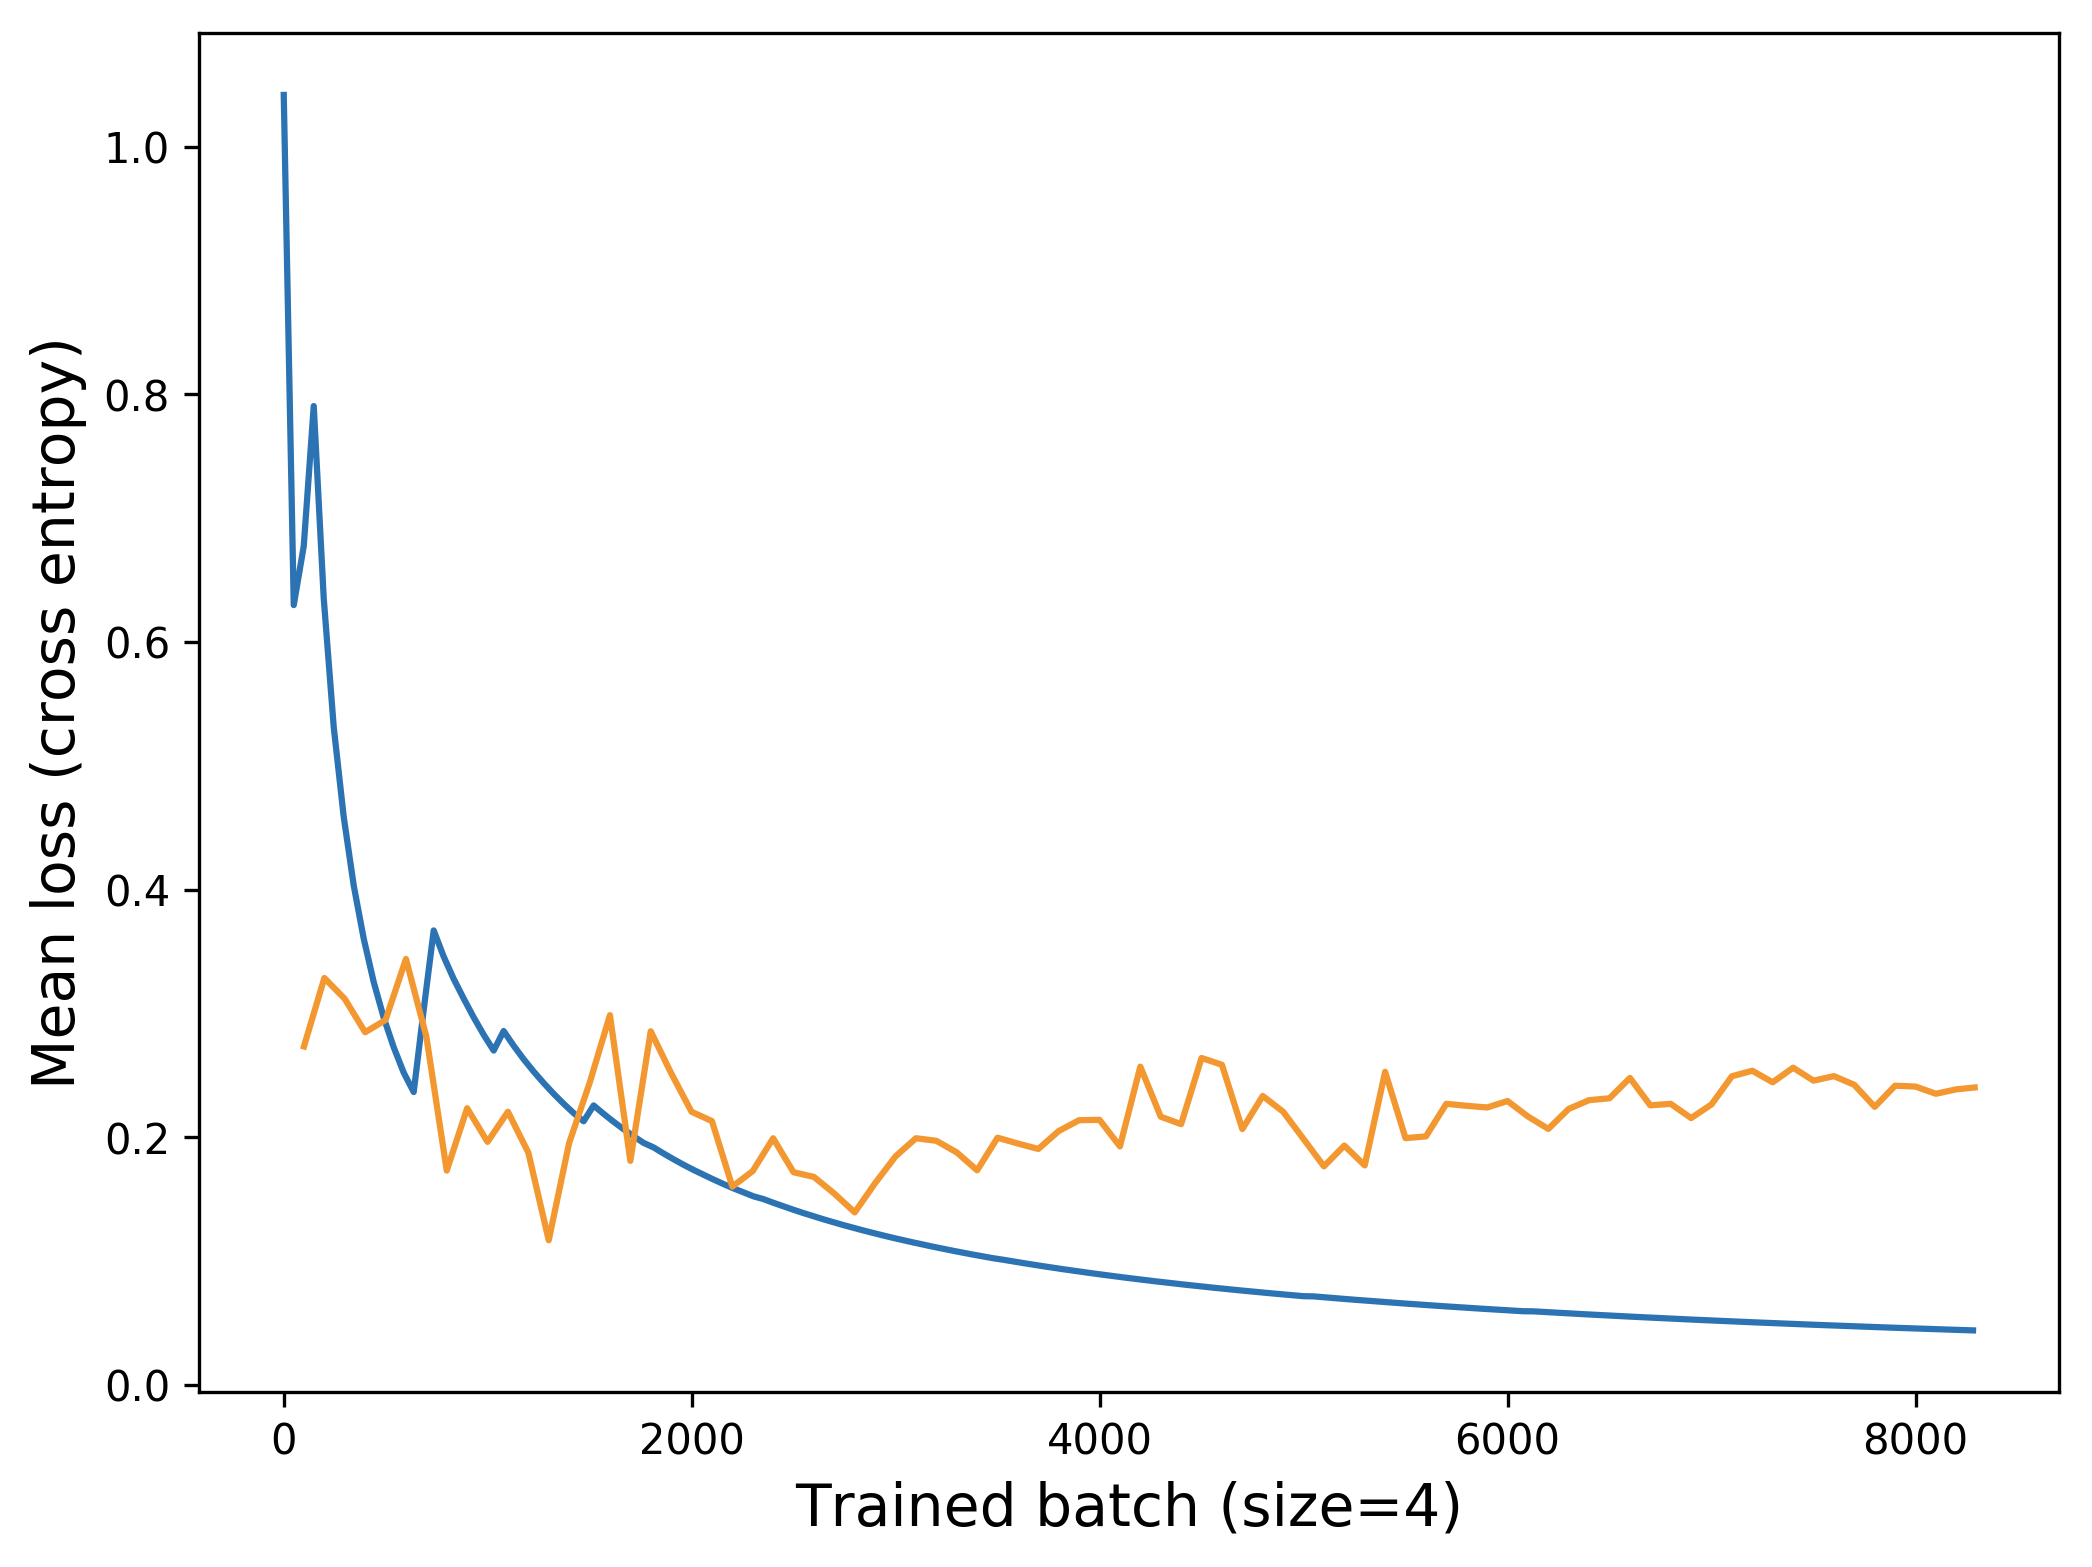

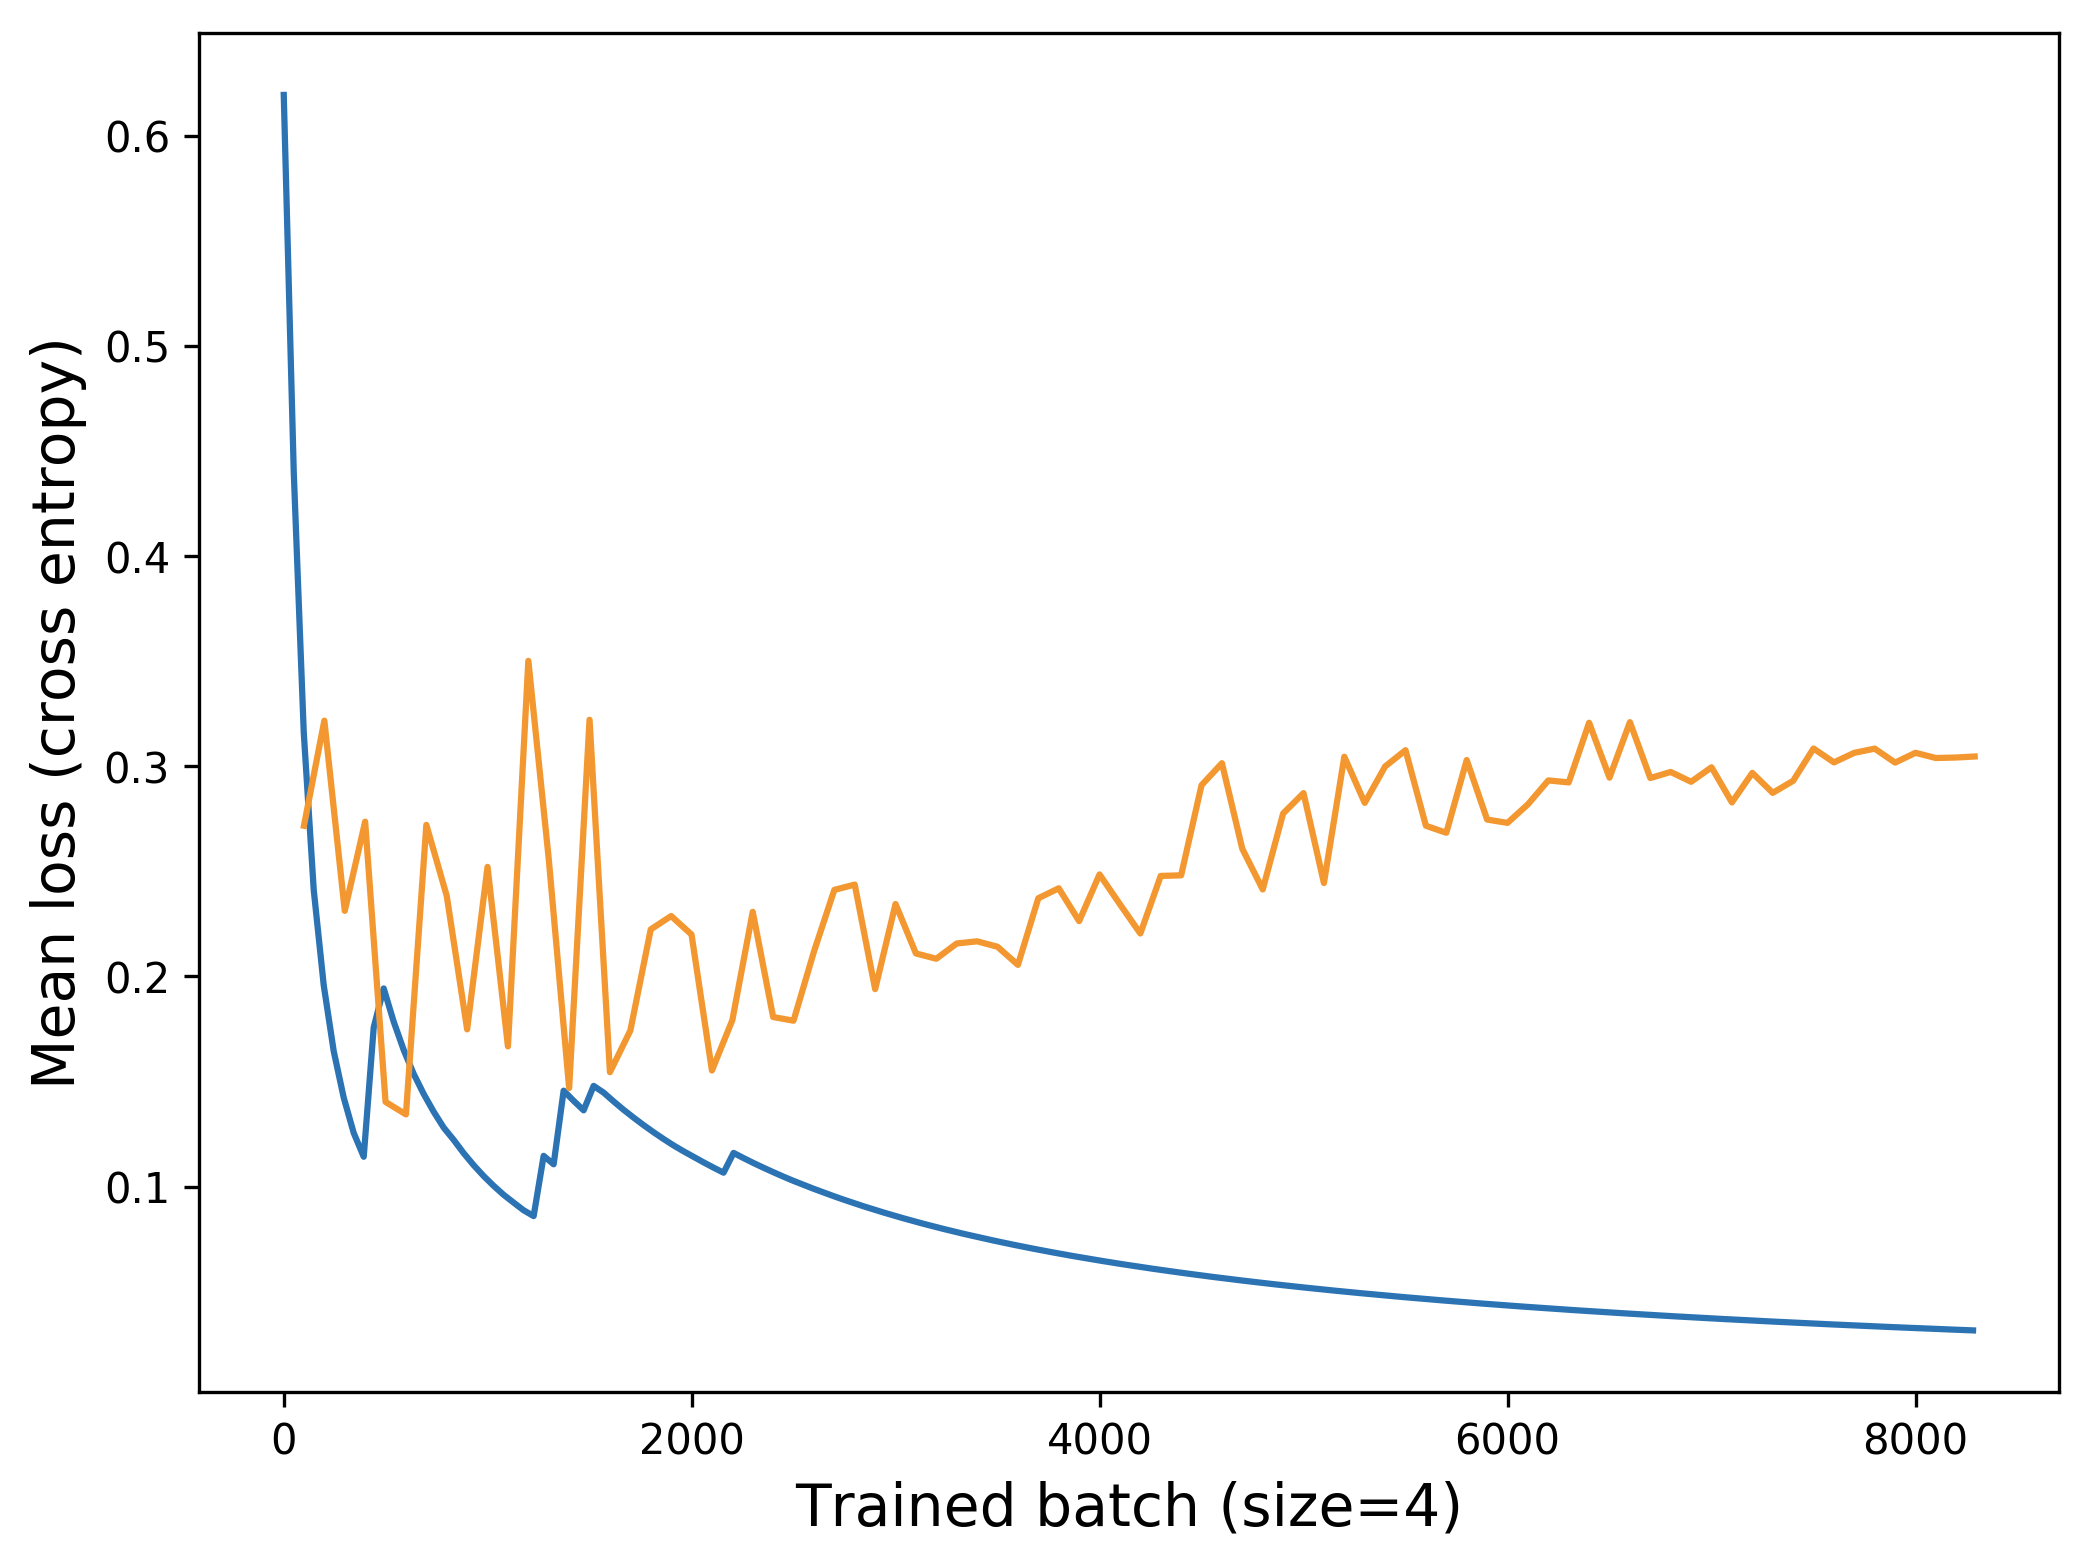

In [163]:
def plot_training_res(training_log, dirc=None):
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    ax.plot(training_log.train_mean_loss['Step'],
                    training_log.train_mean_loss['Value'], color='#2C73B4')
    ax.plot(training_log.eval_mean_loss['Step'],
                    training_log.eval_mean_loss['Value'], color='#F39730')
    ax.set_ylabel('Mean loss (cross entropy)', fontsize=14)
    ax.set_xlabel('Trained batch (size=4)', fontsize=14)
    
    if dirc:
        fig.savefig(dirc, bbox_inches='tight')

    plt.show()
    
plot_training_res(training_log_bert, '/home/yuning/Work/cs-273/figs/bert_training_curve_loss_only.jpeg')
plot_training_res(training_log_bioBert, '/home/yuning/Work/cs-273/figs/biobert_training_curve_loss_only.jpeg')

In [202]:
def plot_training_res(training_log, dirc=None):
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=[8, 6])
    
    axes[0, 0].plot(training_log.train_mean_loss['Step'],
                    training_log.train_mean_loss['Value'], color='#2C73B4')
    axes[0, 0].plot(training_log.eval_mean_loss['Step'],
                    training_log.eval_mean_loss['Value'], color='#F39730')
    axes[0, 0].set_ylabel('Mean loss (cross entropy)', fontsize=12)
    
    
    axes[0, 1].plot(training_log.train_accuracy['Step'],
                  training_log.train_accuracy['Value'], color='#2C73B4')
    axes[0, 1].plot(training_log.eval_accuracy['Step'],
                  training_log.eval_accuracy['Value'], '#F39730')
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_ylim([0, 1.1])
    
    
    axes[1, 0].plot(training_log.train_precision['Step'],
                  training_log.train_precision['Value'], color='#2C73B4')
    axes[1, 0].plot(training_log.eval_precision['Step'],
                  training_log.eval_precision['Value'], color='#F39730')
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].set_ylim([0, 1.1])
    
    
    axes[1, 1].plot(training_log.train_recall['Step'],
                  training_log.train_recall['Value'], color='#2C73B4')
    axes[1, 1].plot(training_log.eval_recall['Step'],
                  training_log.eval_recall['Value'], color='#F39730')
    axes[1, 1].set_ylabel('Recall', fontsize=12)
    axes[1, 1].set_ylim([0, 1.1])
    fig.text(s='Trained batch (size=4)', x=0.5, y=0, fontsize=14, ha='center', va='top')
    plt.tight_layout()
    if dirc:
        fig.savefig(dirc, bbox_inches='tight')

    plt.show()

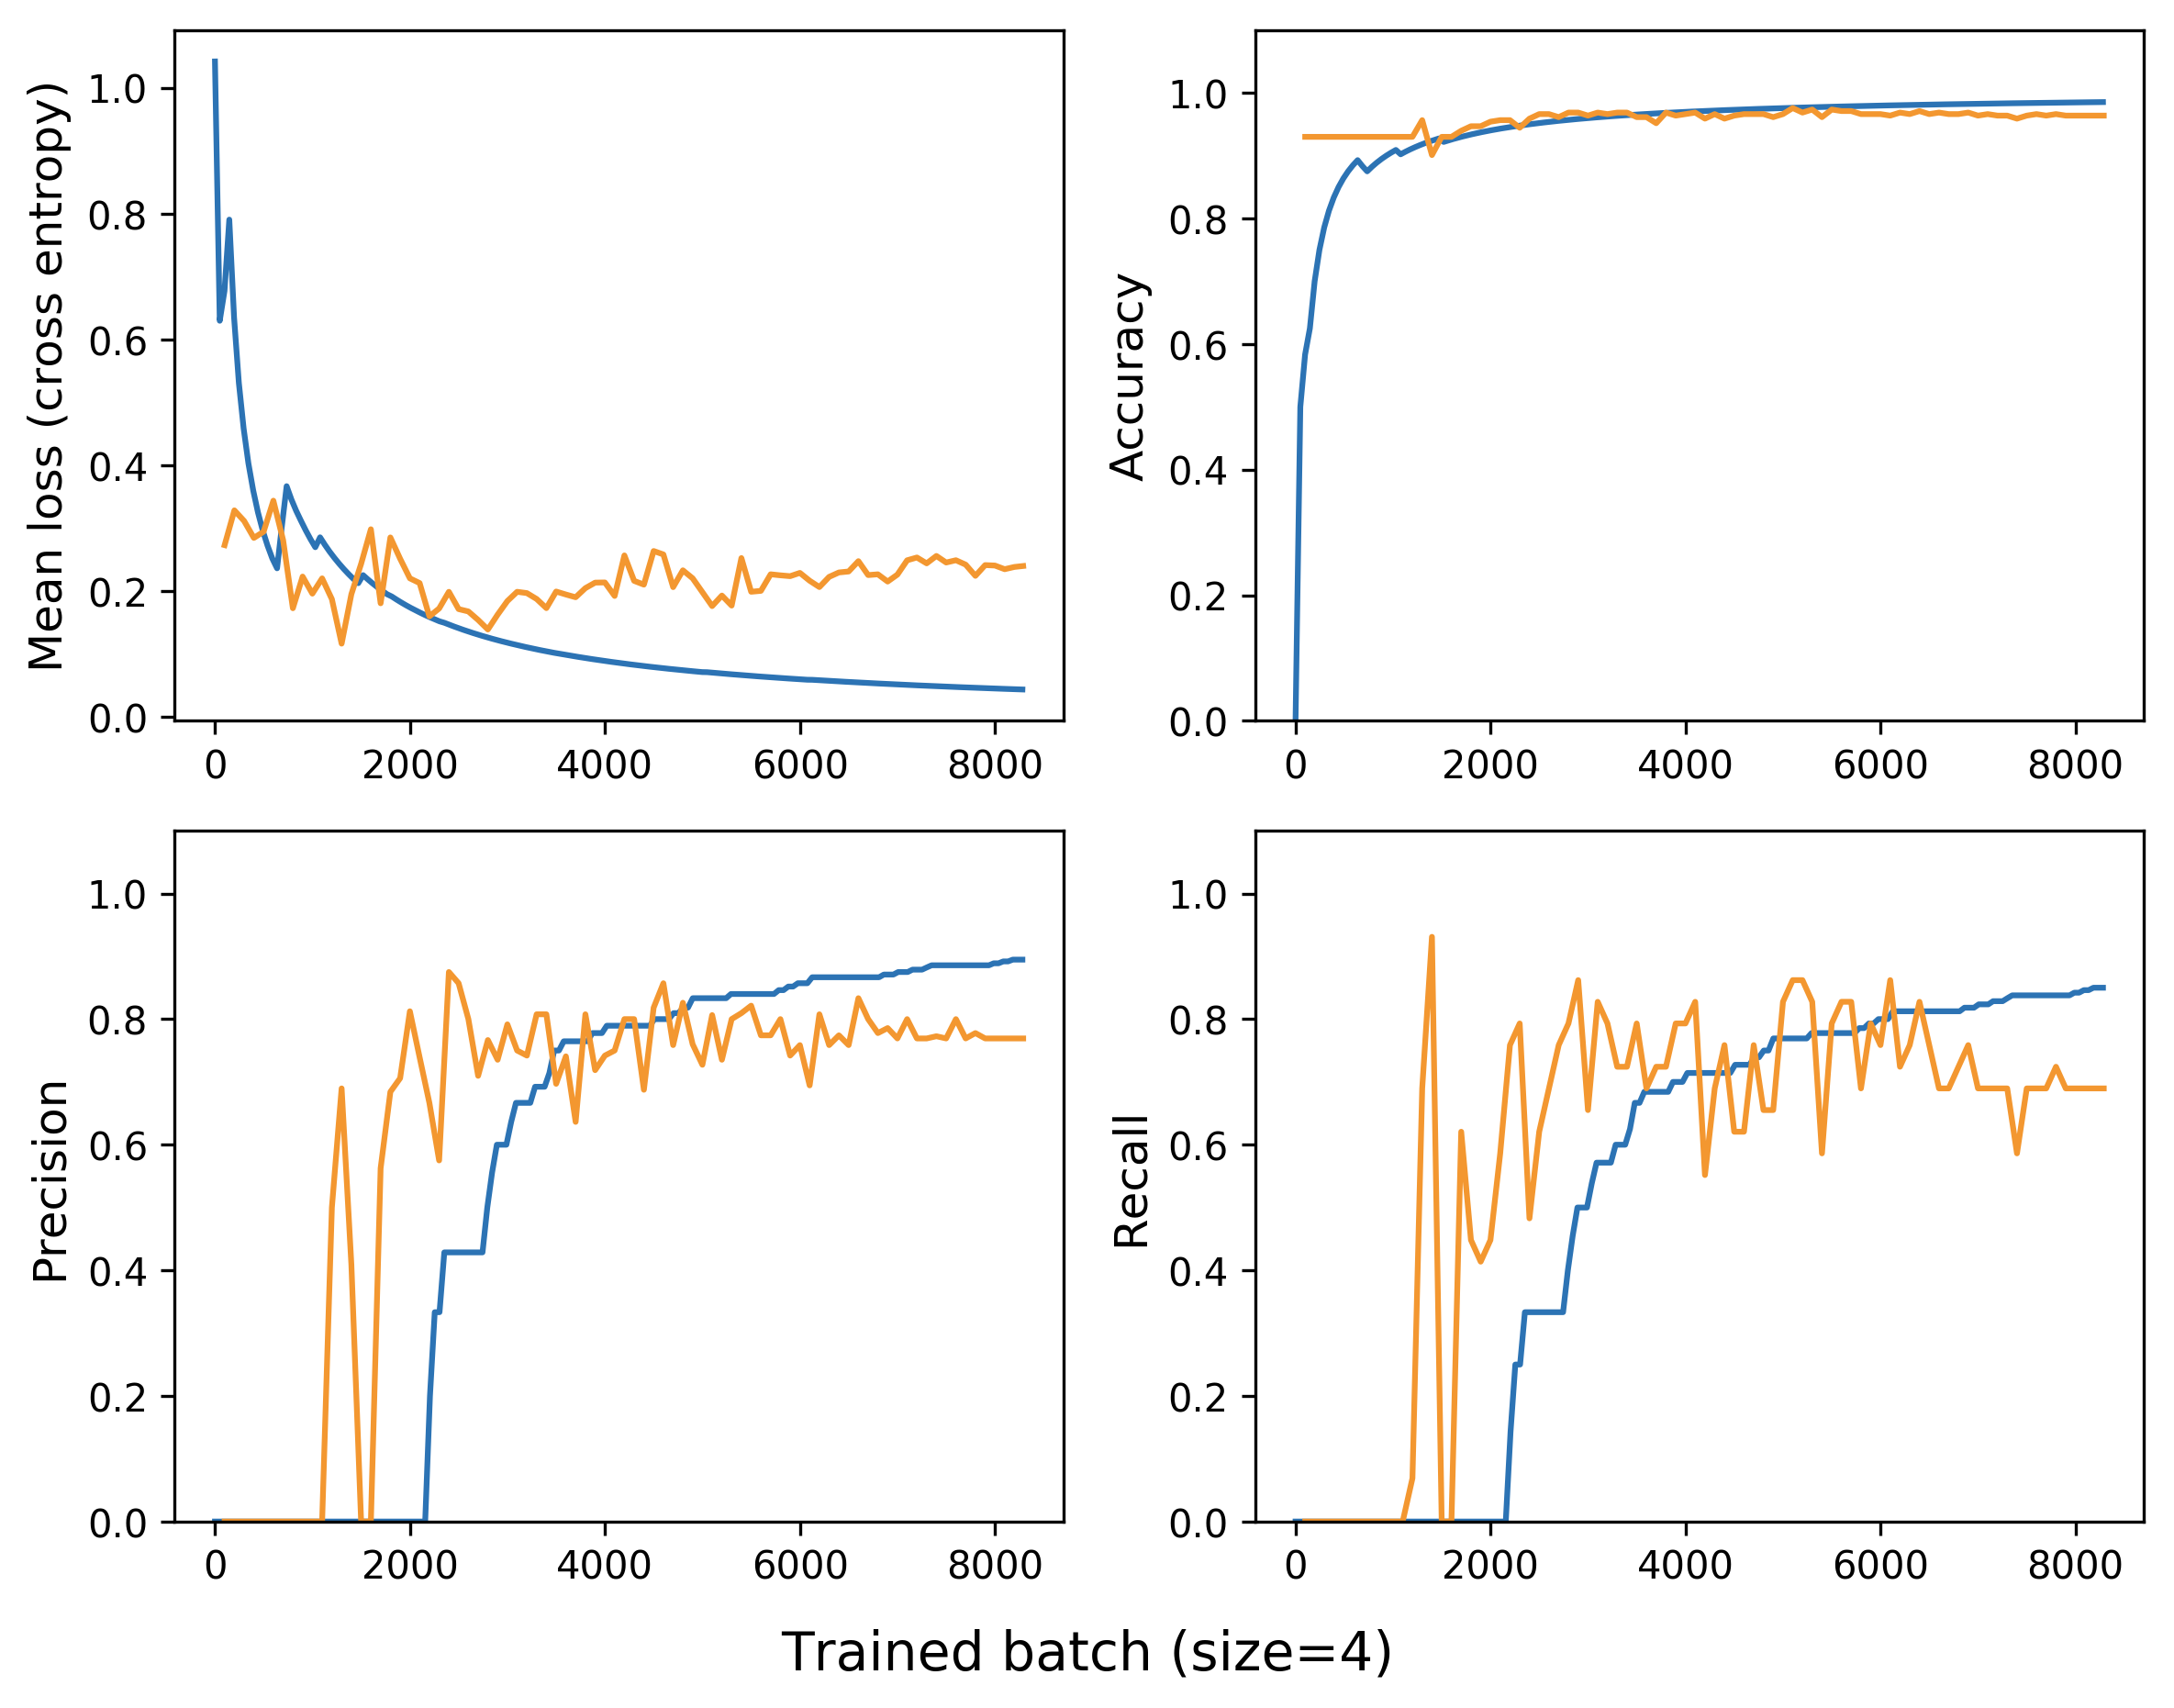

Best model in BERT models between step 2000 to 8000
{'accuracy': 0.968599021434784,
 'f1': 0.872110065669542,
 'mean_loss': 0.13940230011940002,
 'precision': 0.7666666507720947,
 'recall': 0.7931034564971924,
 'step': 2800.0}


In [281]:
plot_training_res(training_log_bert, '/home/yuning/Work/cs-273/figs/bert_training_curve.jpeg')
print(util.color.BOLD + util.color.BLUE + \
'Best model in BERT models between step 2000 to 8000' + util.color.END)
pprint.pprint(report_best_model(training_log_bert, step_range=[2000, 8000]))

Best model in BioBERT models from step 2000 to 9000


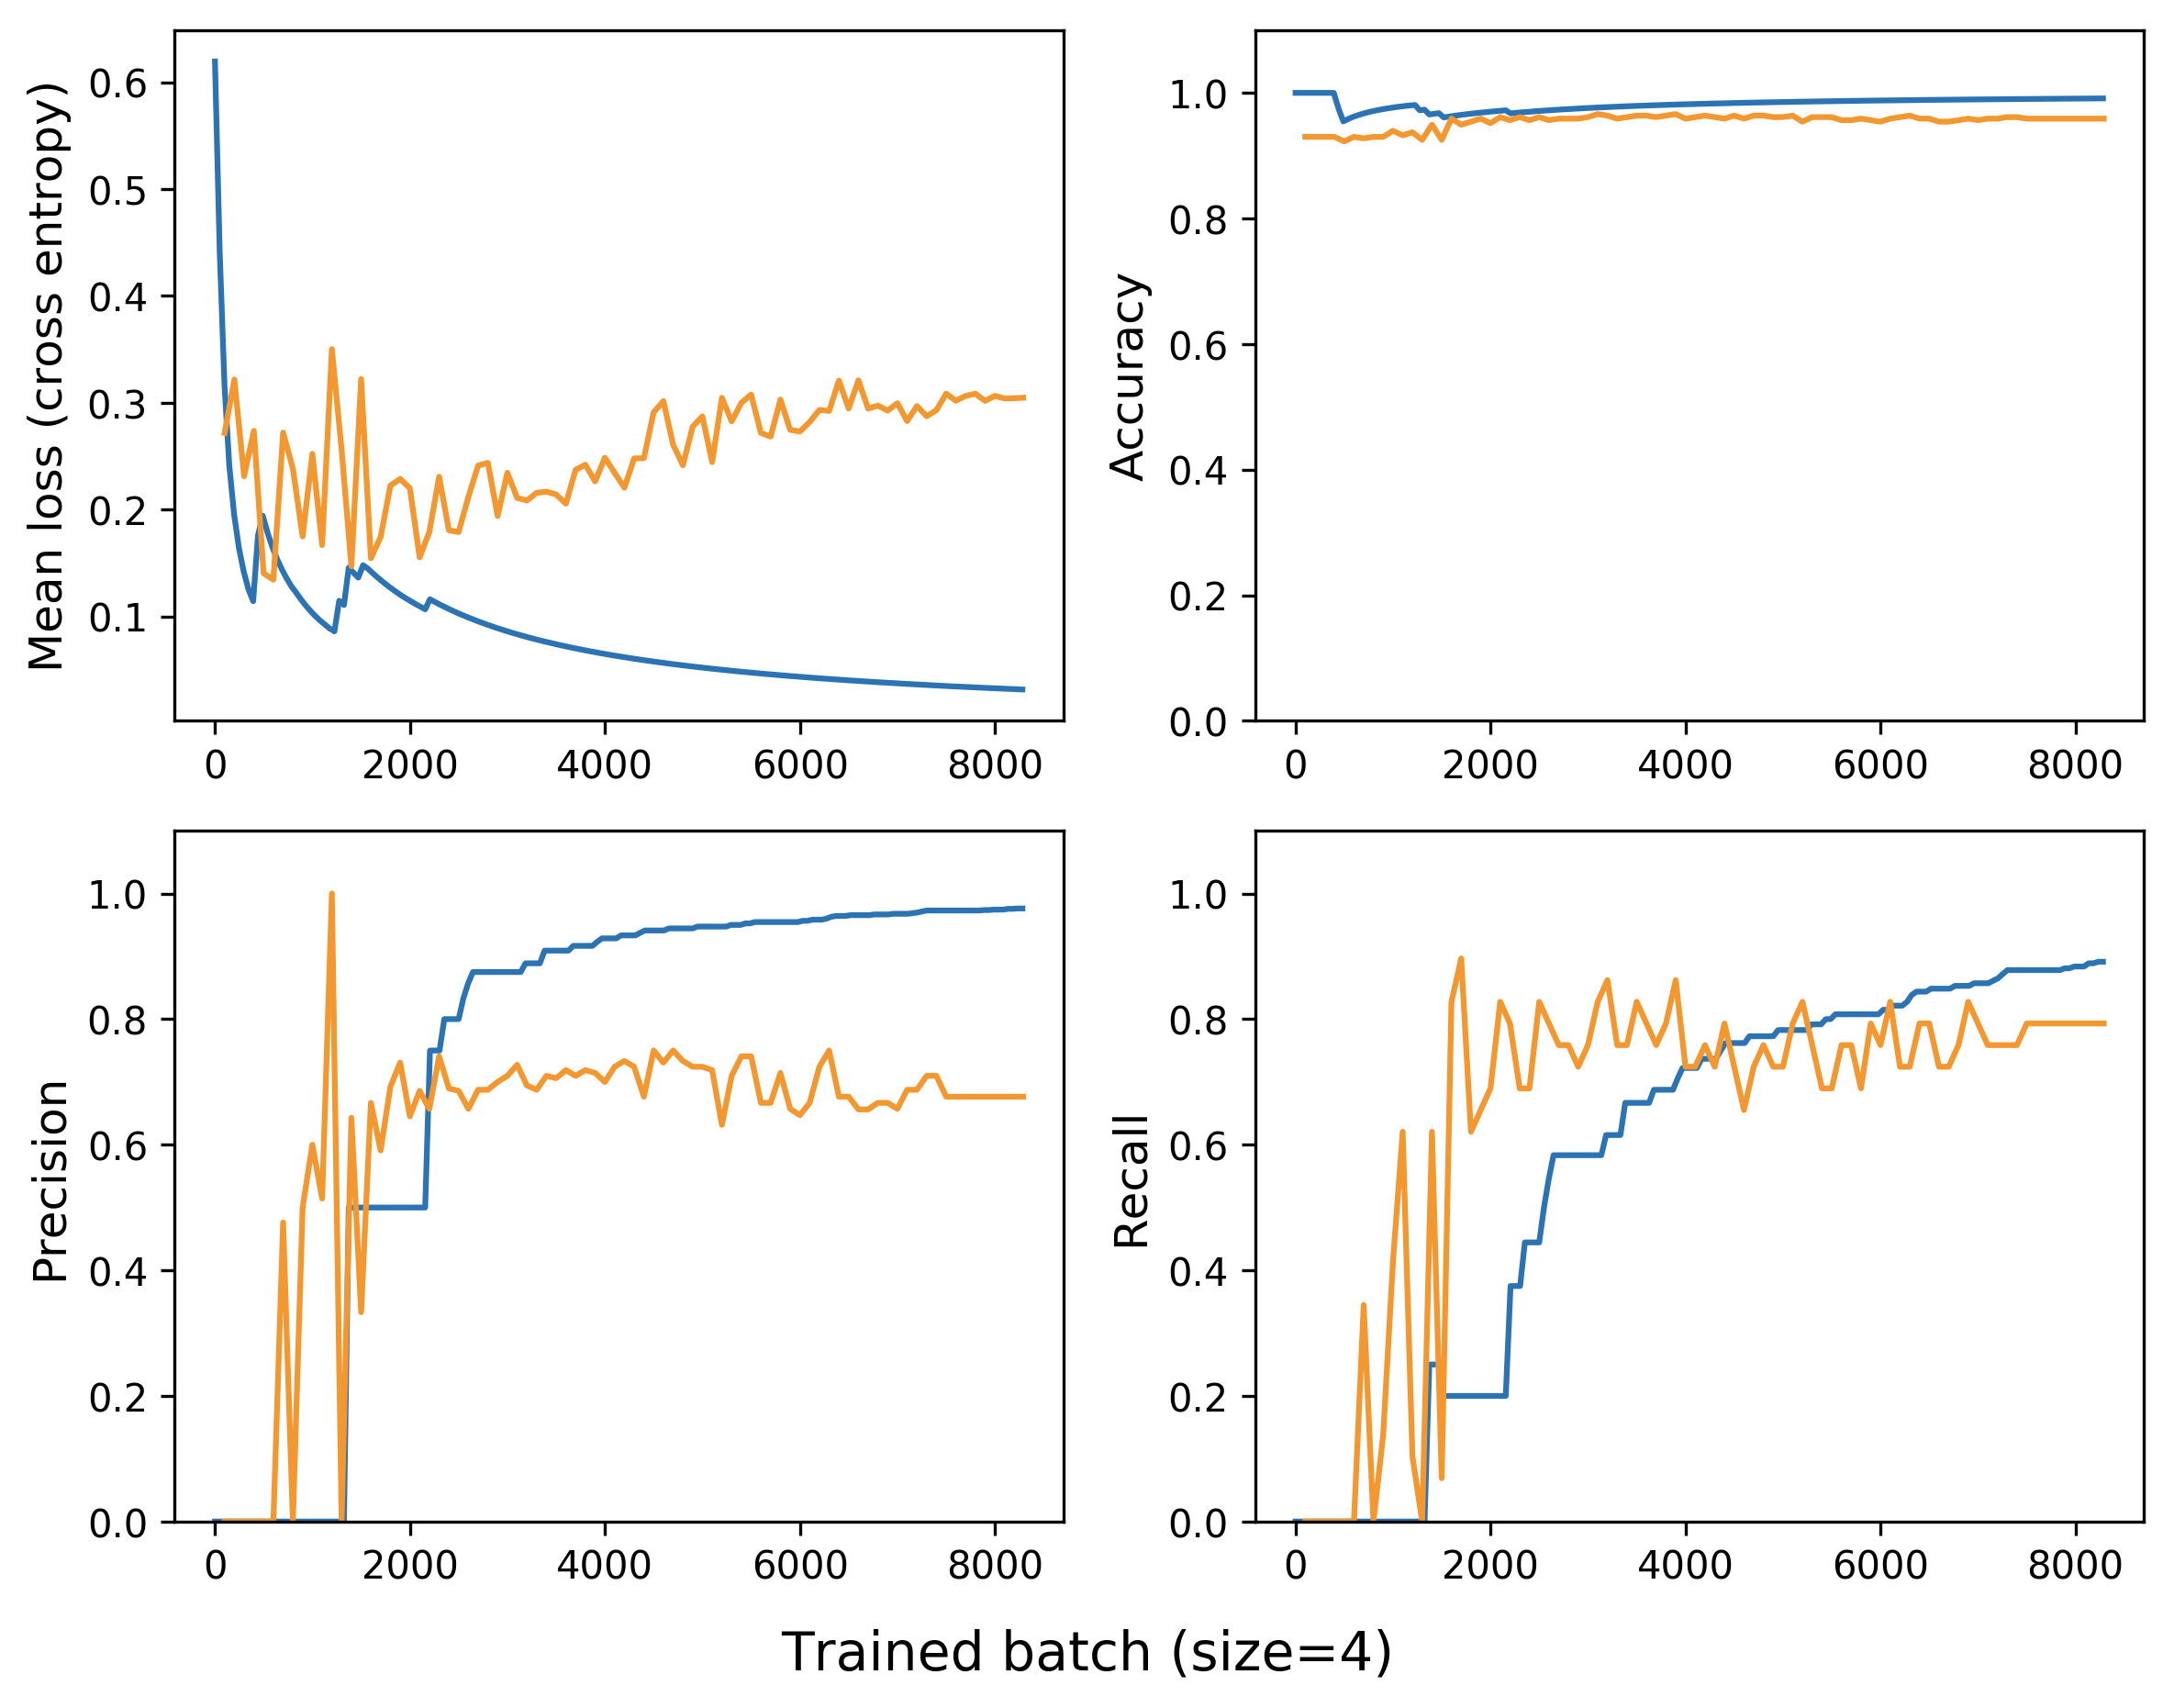

{'accuracy': 0.9613526463508606,
 'f1': 0.8894683040093097,
 'mean_loss': 0.15521101653575894,
 'precision': 0.6857143044471741,
 'recall': 0.8275862336158752,
 'step': 2100.0}


In [283]:
print(util.color.BOLD + util.color.BLUE + \
'Best model in BioBERT models from step 2000 to 9000' + util.color.END)

plot_training_res(training_log_bioBert, '/home/yuning/Work/cs-273/figs/biobert_training_curve.jpeg')
pprint.pprint(report_best_model(training_log_bioBert, step_range=[2000, 9000]))

# Cross validation results

In [284]:
def plot_cv_log(cv_log, dirc=None):
    
    fig, axes = plt.subplots(2, 2, figsize=[14, 10])

    data_to_plot = [
        cv_log.train_1_mean_loss,
        cv_log.train_2_mean_loss,
        cv_log.train_3_mean_loss,
        cv_log.train_4_mean_loss,
        cv_log.train_5_mean_loss
    ]

    for data in data_to_plot:
        axes[0, 0].plot(data['Step'], data['Value'], '#2C73B4', alpha=0.5)

    data_to_plot = [
        cv_log.eval_1_mean_loss,
        cv_log.eval_2_mean_loss,
        cv_log.eval_3_mean_loss,
        cv_log.eval_4_mean_loss,
        cv_log.eval_5_mean_loss
    ]
    for data in data_to_plot:
        axes[0, 0].plot(data['Step'], data['Value'], '#F39730', alpha=0.5)
    # ax.set_xlabel('Training batch (size=4)', fontsize=14)
    axes[0, 0].set_ylabel('Mean loss per sample', fontsize=14)


    data_to_plot = [
        cv_log.train_1_accuracy,
        cv_log.train_2_accuracy,
        cv_log.train_3_accuracy,
        cv_log.train_4_accuracy,
        cv_log.train_5_accuracy
    ]

    for data in data_to_plot:
        axes[0, 1].plot(data['Step'], data['Value'], '#2C73B4', alpha=0.5)

    data_to_plot = [
        cv_log.eval_1_accuracy,
        cv_log.eval_2_accuracy,
        cv_log.eval_3_accuracy,
        cv_log.eval_4_accuracy,
        cv_log.eval_5_accuracy
    ]
    for data in data_to_plot:
        axes[0, 1].plot(data['Step'], data['Value'], '#F39730', alpha=0.5)
    # ax.set_xlabel('Training batch (size=4)', fontsize=14)
    axes[0, 1].set_ylabel('Accuracy', fontsize=14)


    data_to_plot = [
        cv_log.train_1_precision,
        cv_log.train_2_precision,
        cv_log.train_3_precision,
        cv_log.train_4_precision,
        cv_log.train_5_precision
    ]

    for data in data_to_plot:
        axes[1, 0].plot(data['Step'], data['Value'], '#2C73B4', alpha=0.5)

    data_to_plot = [
        cv_log.eval_1_precision,
        cv_log.eval_2_precision,
        cv_log.eval_3_precision,
        cv_log.eval_4_precision,
        cv_log.eval_5_precision
    ]
    for data in data_to_plot:
        axes[1, 0].plot(data['Step'], data['Value'], '#F39730', alpha=0.5)
    # ax.set_xlabel('Training batch (size=4)', fontsize=14)
    axes[1, 0].set_ylabel('Precision', fontsize=14)


    data_to_plot = [
        cv_log.train_1_recall,
        cv_log.train_2_recall,
        cv_log.train_3_recall,
        cv_log.train_4_recall,
        cv_log.train_5_recall
    ]

    for data in data_to_plot:
        axes[1, 1].plot(data['Step'], data['Value'], '#2C73B4', alpha=0.5)

    data_to_plot = [
        cv_log.eval_1_recall,
        cv_log.eval_2_recall,
        cv_log.eval_3_recall,
        cv_log.eval_4_recall,
        cv_log.eval_5_recall
    ]
    for data in data_to_plot:
        axes[1, 1].plot(data['Step'], data['Value'], '#F39730', alpha=0.5)
    # ax.set_xlabel('Training batch (size=4)', fontsize=14)
    axes[1, 1].set_ylabel('Recall', fontsize=14)

    fig.text(s='Trained batches (size=4)', fontsize=14, x=0.5, y=0.0, ha='center', va='top')

    plt.tight_layout()

    if dirc:
        plt.savefig(dirc, bbox_inches='tight')

    plt.show()
    
    
def get_cv_best_model_stat(stat_dir, pattern, step_range):
    cv_best_model_stat = pd.DataFrame()
    for set_ix in range(5):
        training_log_cv = TrainingLog.from_csv(
            dirc=stat_dir,
            name_filter='set_{}'.format(set_ix + 1),
            pattern=pattern,
            name_combine=['type', 'tag']
        )
        cv_stat = report_best_model(training_log_cv, step_range=step_range)
        stat_res= pd.DataFrame([cv_stat], columns=cv_stat.keys(), index=[set_ix + 1])
        cv_best_model_stat = pd.concat([cv_best_model_stat, stat_res])
    return cv_best_model_stat

## BERT Unweighted

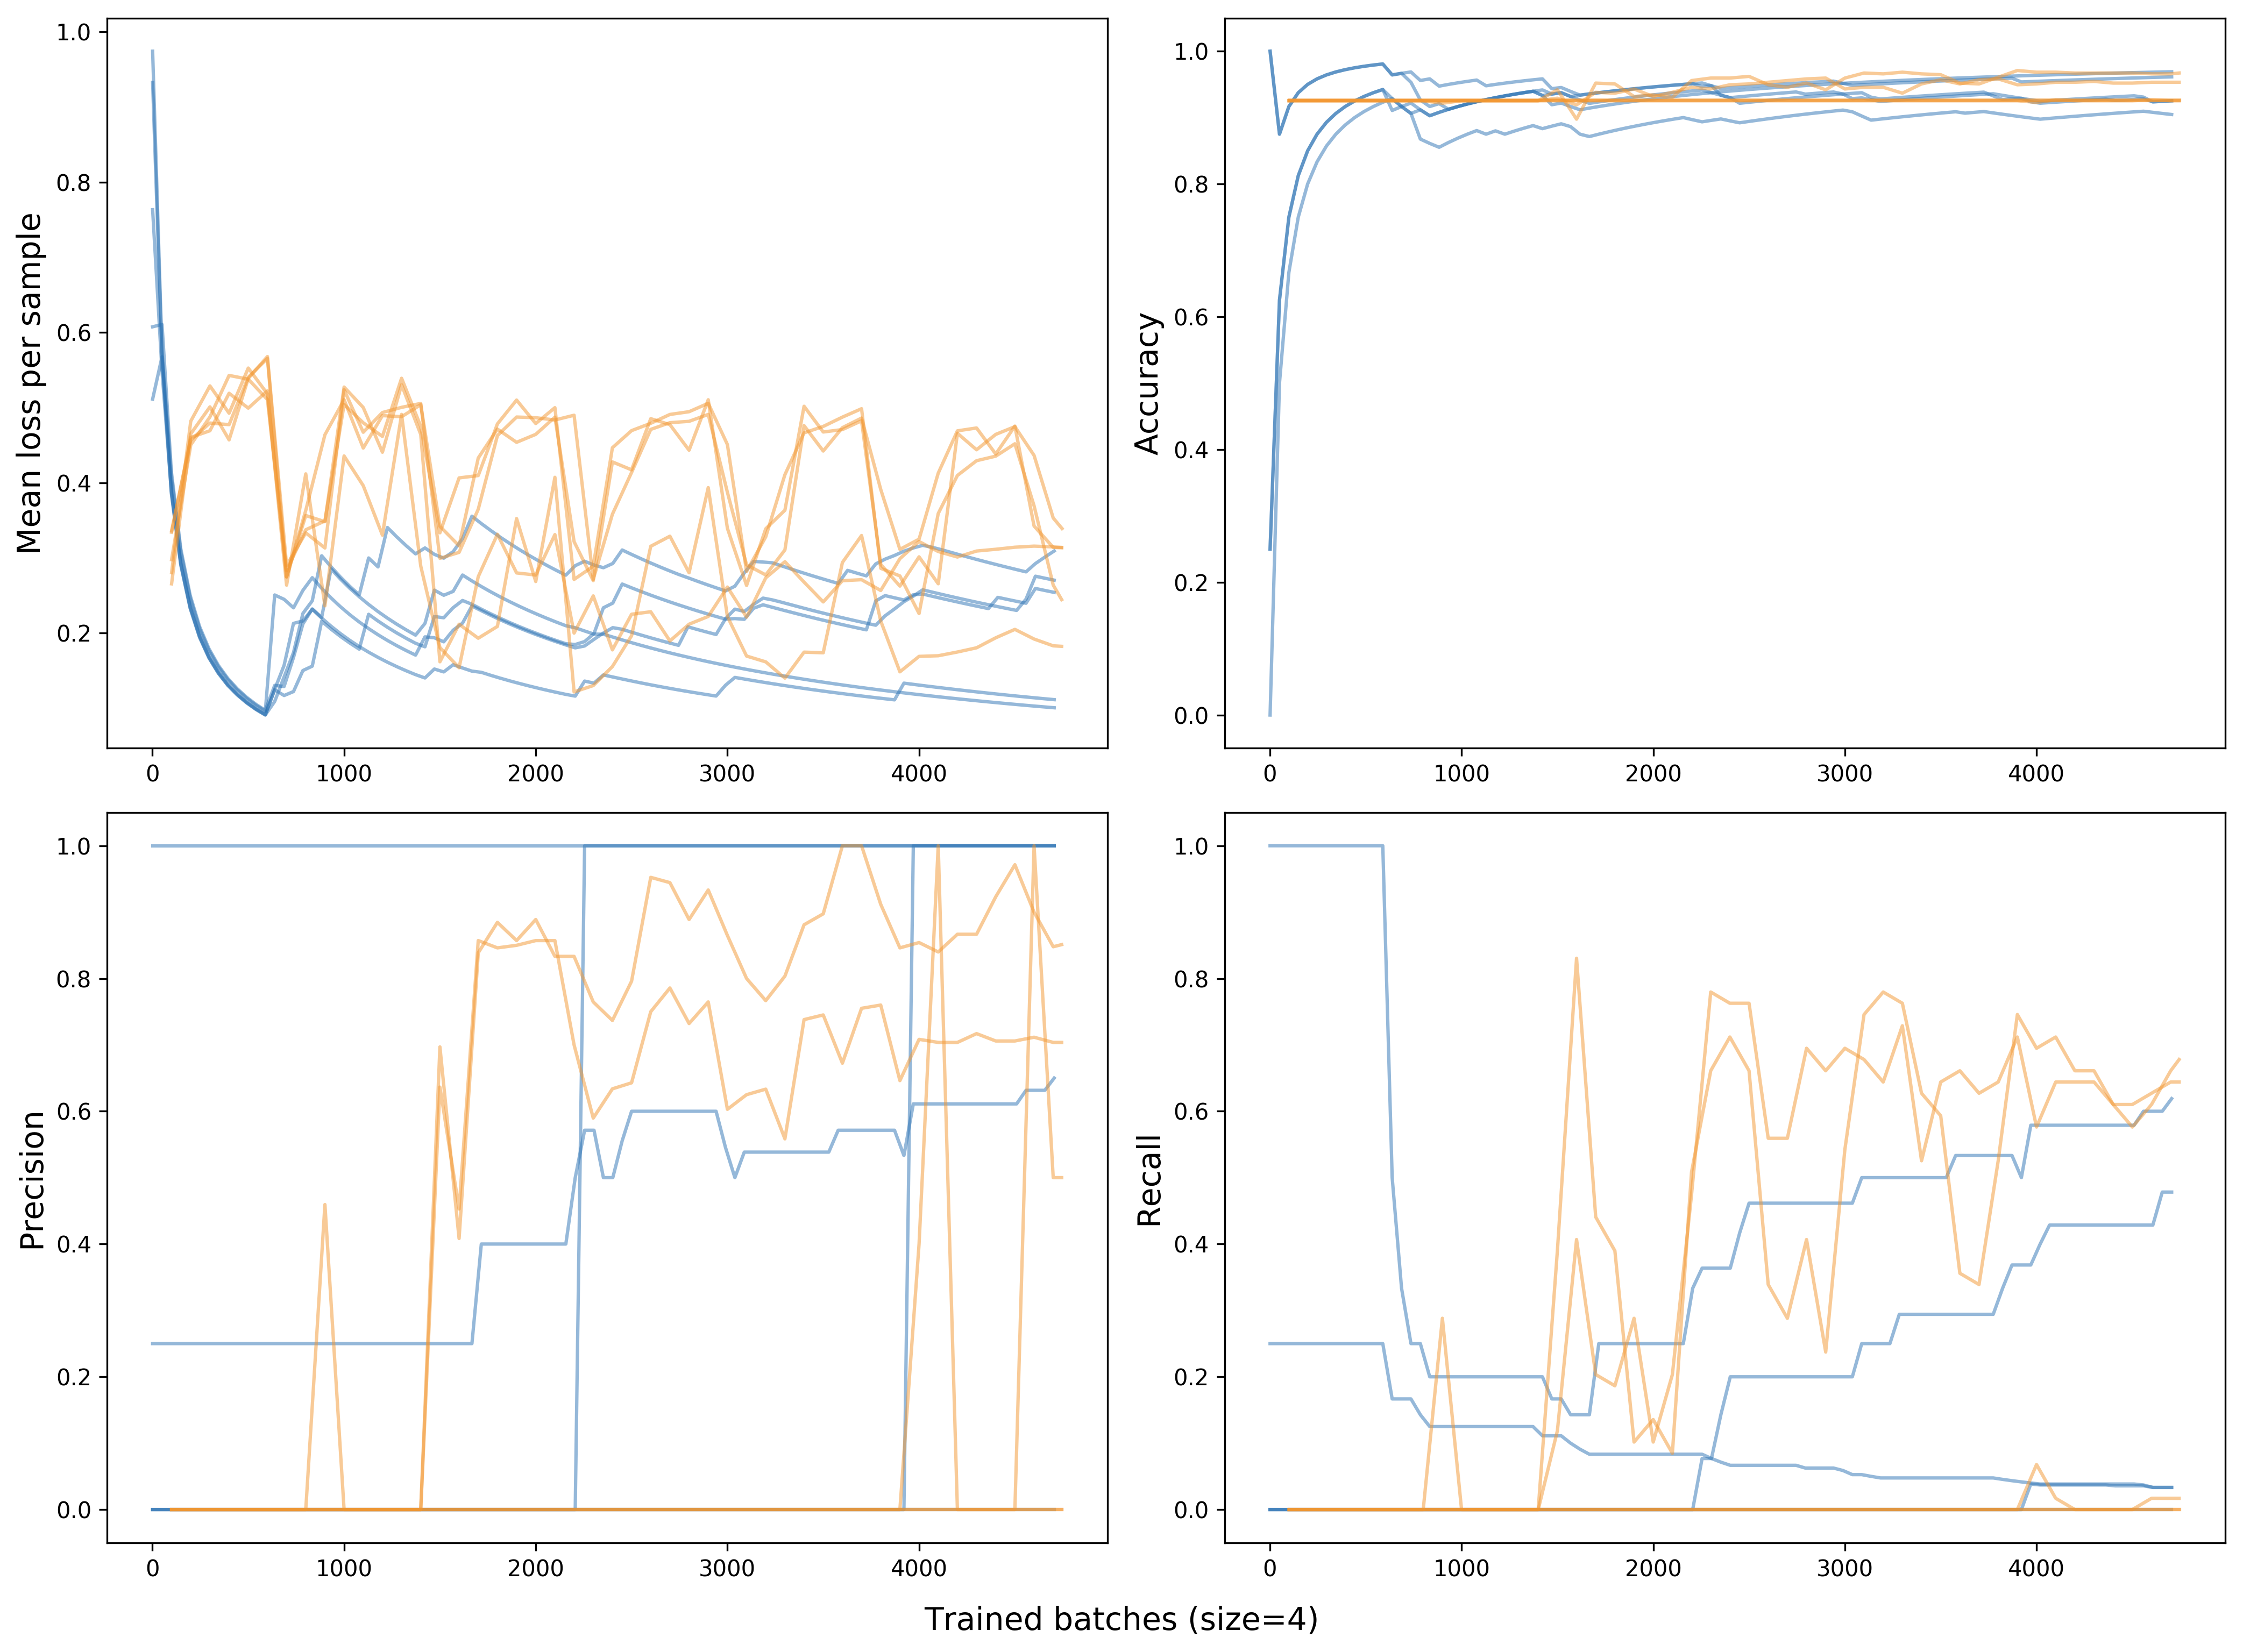

In [286]:
cv_log = TrainingLog.from_csv(
    dirc='/mnt/storage/projects/cs-273/tf_curves/tf_cv_res/Bert/',
    pattern='run_[{model}_6_epoch_set_{set_num}{type}tag-{tag}].csv',
    name_combine=['type', 'set_num', 'tag']
)
plot_cv_log(cv_log, '/home/yuning/Work/cs-273/figs/bert_cv_all.jpeg')

In [287]:
cv_best_model_stat = get_cv_best_model_stat(
    stat_dir='/mnt/storage/projects/cs-273/tf_curves/tf_cv_res/Bert/',
    pattern='run_[{model}_6_epoch_set_{set_num}{type}tag-{tag}].csv',
    step_range=[3000, 9000]
)
cv_best_model_stat

step  mean_loss  accuracy  precision    recall        f1  roc_auc_max  \
1  3200.0   0.277332  0.925411   0.000000  0.000000  0.000000     1.000000   
2  3300.0   0.140095  0.968394   0.803571  0.762712  0.853334     0.996434   
3  3100.0   0.221194  0.945638   0.625000  0.677966  0.789738     0.989442   
4  4000.0   0.225960  0.922882   0.400000  0.067797  0.126314     0.992359   
5  3900.0   0.262519  0.926582   0.000000  0.000000  0.000000     1.000000   

    roc_auc_min  
1  1.694915e-08  
2  7.512503e-01  
3  6.557377e-01  
4  6.724092e-02  
5  1.724138e-08

In [288]:
cv_best_model_stat.iloc[1:4].describe()

step  mean_loss  accuracy  precision    recall        f1  \
count     3.000000   3.000000  3.000000   3.000000  3.000000  3.000000   
mean   3466.666667   0.195750  0.945638   0.609524  0.502825  0.589795   
std     472.581563   0.048258  0.022756   0.202230  0.379121  0.402644   
min    3100.000000   0.140095  0.922882   0.400000  0.067797  0.126314   
25%    3200.000000   0.180644  0.934260   0.512500  0.372881  0.458026   
50%    3300.000000   0.221194  0.945638   0.625000  0.677966  0.789738   
75%    3650.000000   0.223577  0.957016   0.714286  0.720339  0.821536   
max    4000.000000   0.225960  0.968394   0.803571  0.762712  0.853334   

       roc_auc_max  roc_auc_min  
count     3.000000     3.000000  
mean      0.992745     0.491410  
std       0.003512     0.370432  
min       0.989442     0.067241  
25%       0.990900     0.361489  
50%       0.992359     0.655738  
75%       0.994397     0.703494  
max       0.996434     0.751250

## BioBert

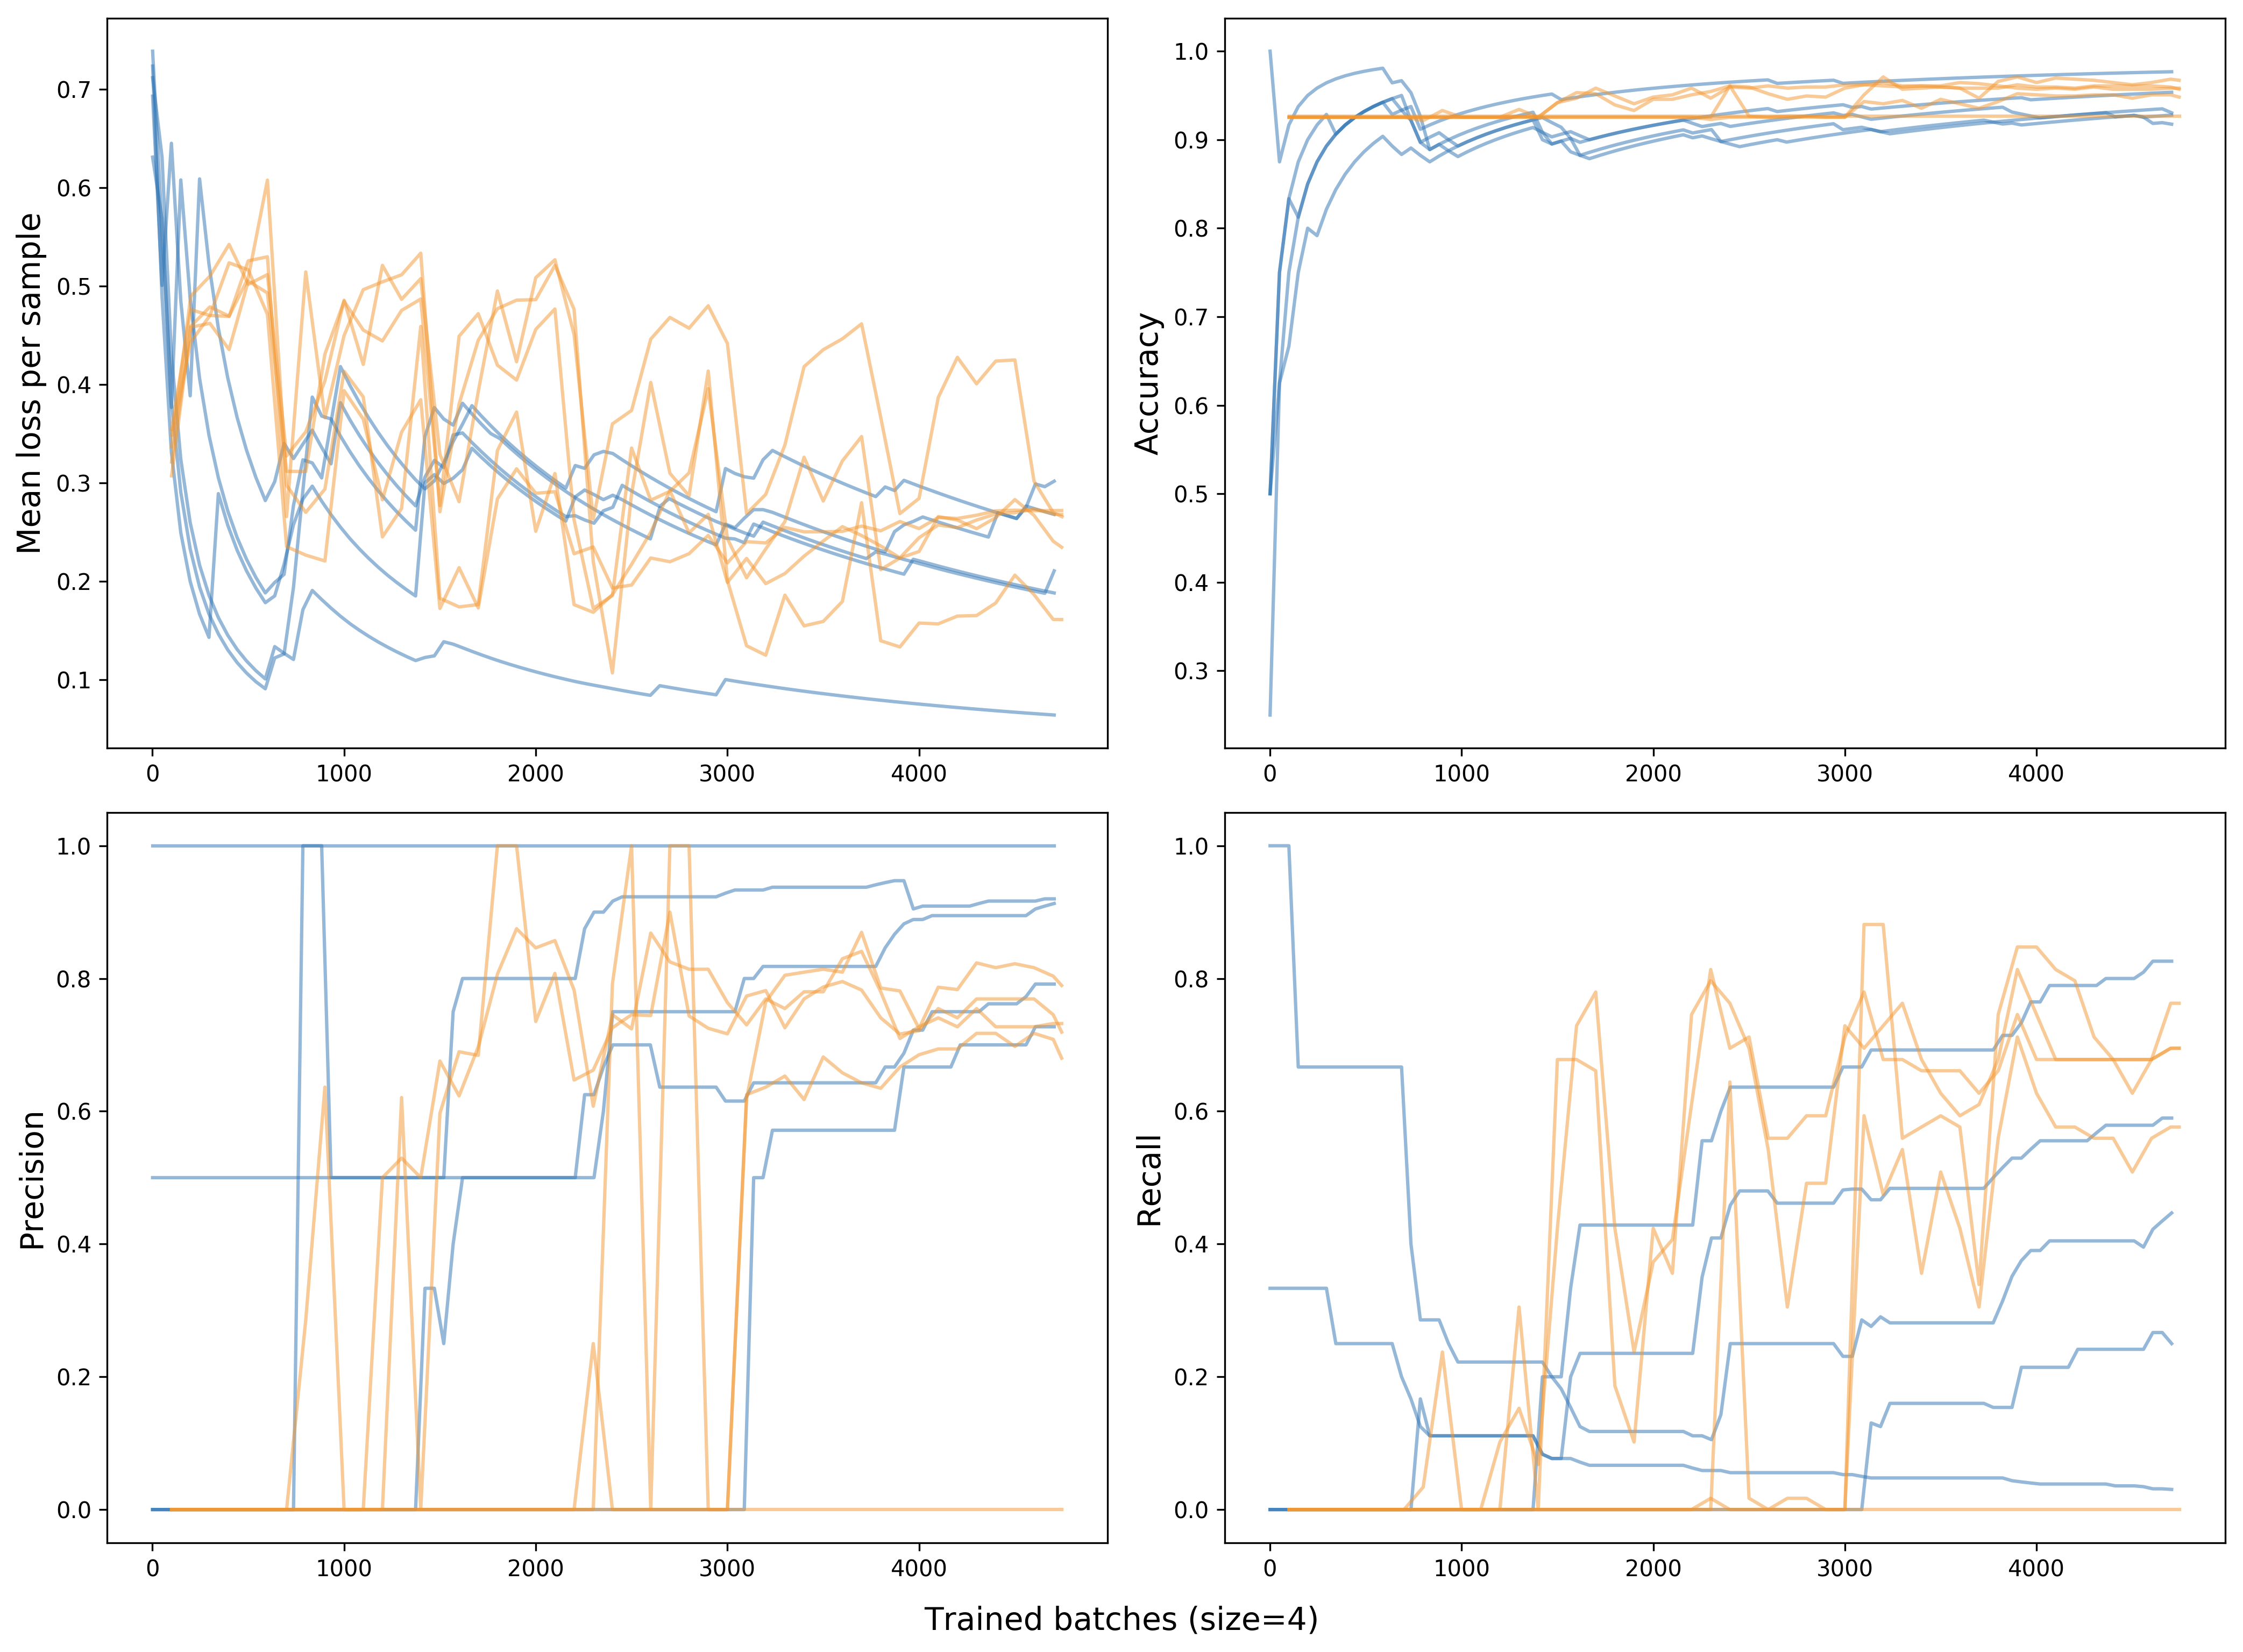

In [289]:
cv_log = TrainingLog.from_csv(
    dirc='/mnt/storage/projects/cs-273/tf_curves/tf_cv_res/BioBert/',
    pattern='run_[{model}_6_epoch_set_{set_num}{type}tag-{tag}].csv',
    name_combine=['type', 'set_num', 'tag']
)
plot_cv_log(cv_log, '/home/yuning/Work/cs-273/figs/biobert_cv_all.jpeg')

In [290]:
cv_best_model_stat = get_cv_best_model_stat(
    stat_dir='/mnt/storage/projects/cs-273/tf_curves/tf_cv_res/BioBert/',
    pattern='run_[{model}_6_epoch_set_{set_num}{type}tag-{tag}].csv',
    step_range=[3500, 9000]
)
cv_best_model_stat

step  mean_loss  accuracy  precision    recall        f1  roc_auc_max  \
1  3800.0   0.211942  0.943110   0.634615  0.559322  0.702198     0.988562   
2  3900.0   0.133428  0.970923   0.781250  0.847458  0.904999     0.997083   
3  3900.0   0.223945  0.962073   0.716418  0.813559  0.881605     0.995161   
4  3600.0   0.250900  0.964602   0.829787  0.661017  0.784462     0.996295   
5  4746.0   0.265781  0.926582   0.000000  0.000000  0.000000     1.000000   

    roc_auc_min  
1  5.448042e-01  
2  8.312494e-01  
3  7.924423e-01  
4  6.537927e-01  
5  1.724138e-08

In [291]:
cv_best_model_stat.iloc[:4].describe()

step  mean_loss  accuracy  precision    recall        f1  \
count     4.000000   4.000000  4.000000   4.000000  4.000000  4.000000   
mean   3800.000000   0.205054  0.960177   0.740518  0.720339  0.818316   
std     141.421356   0.050453  0.011971   0.084507  0.134530  0.093361   
min    3600.000000   0.133428  0.943110   0.634615  0.559322  0.702198   
25%    3750.000000   0.192314  0.957332   0.695967  0.635593  0.763896   
50%    3850.000000   0.217944  0.963338   0.748834  0.737288  0.833034   
75%    3900.000000   0.230684  0.966182   0.793384  0.822034  0.887454   
max    3900.000000   0.250900  0.970923   0.829787  0.847458  0.904999   

       roc_auc_max  roc_auc_min  
count     4.000000     4.000000  
mean      0.994275     0.705572  
std       0.003890     0.131490  
min       0.988562     0.544804  
25%       0.993511     0.626546  
50%       0.995728     0.723118  
75%       0.996492     0.802144  
max       0.997083     0.831249

# Weighted cost function
## BioBert 8 epochs

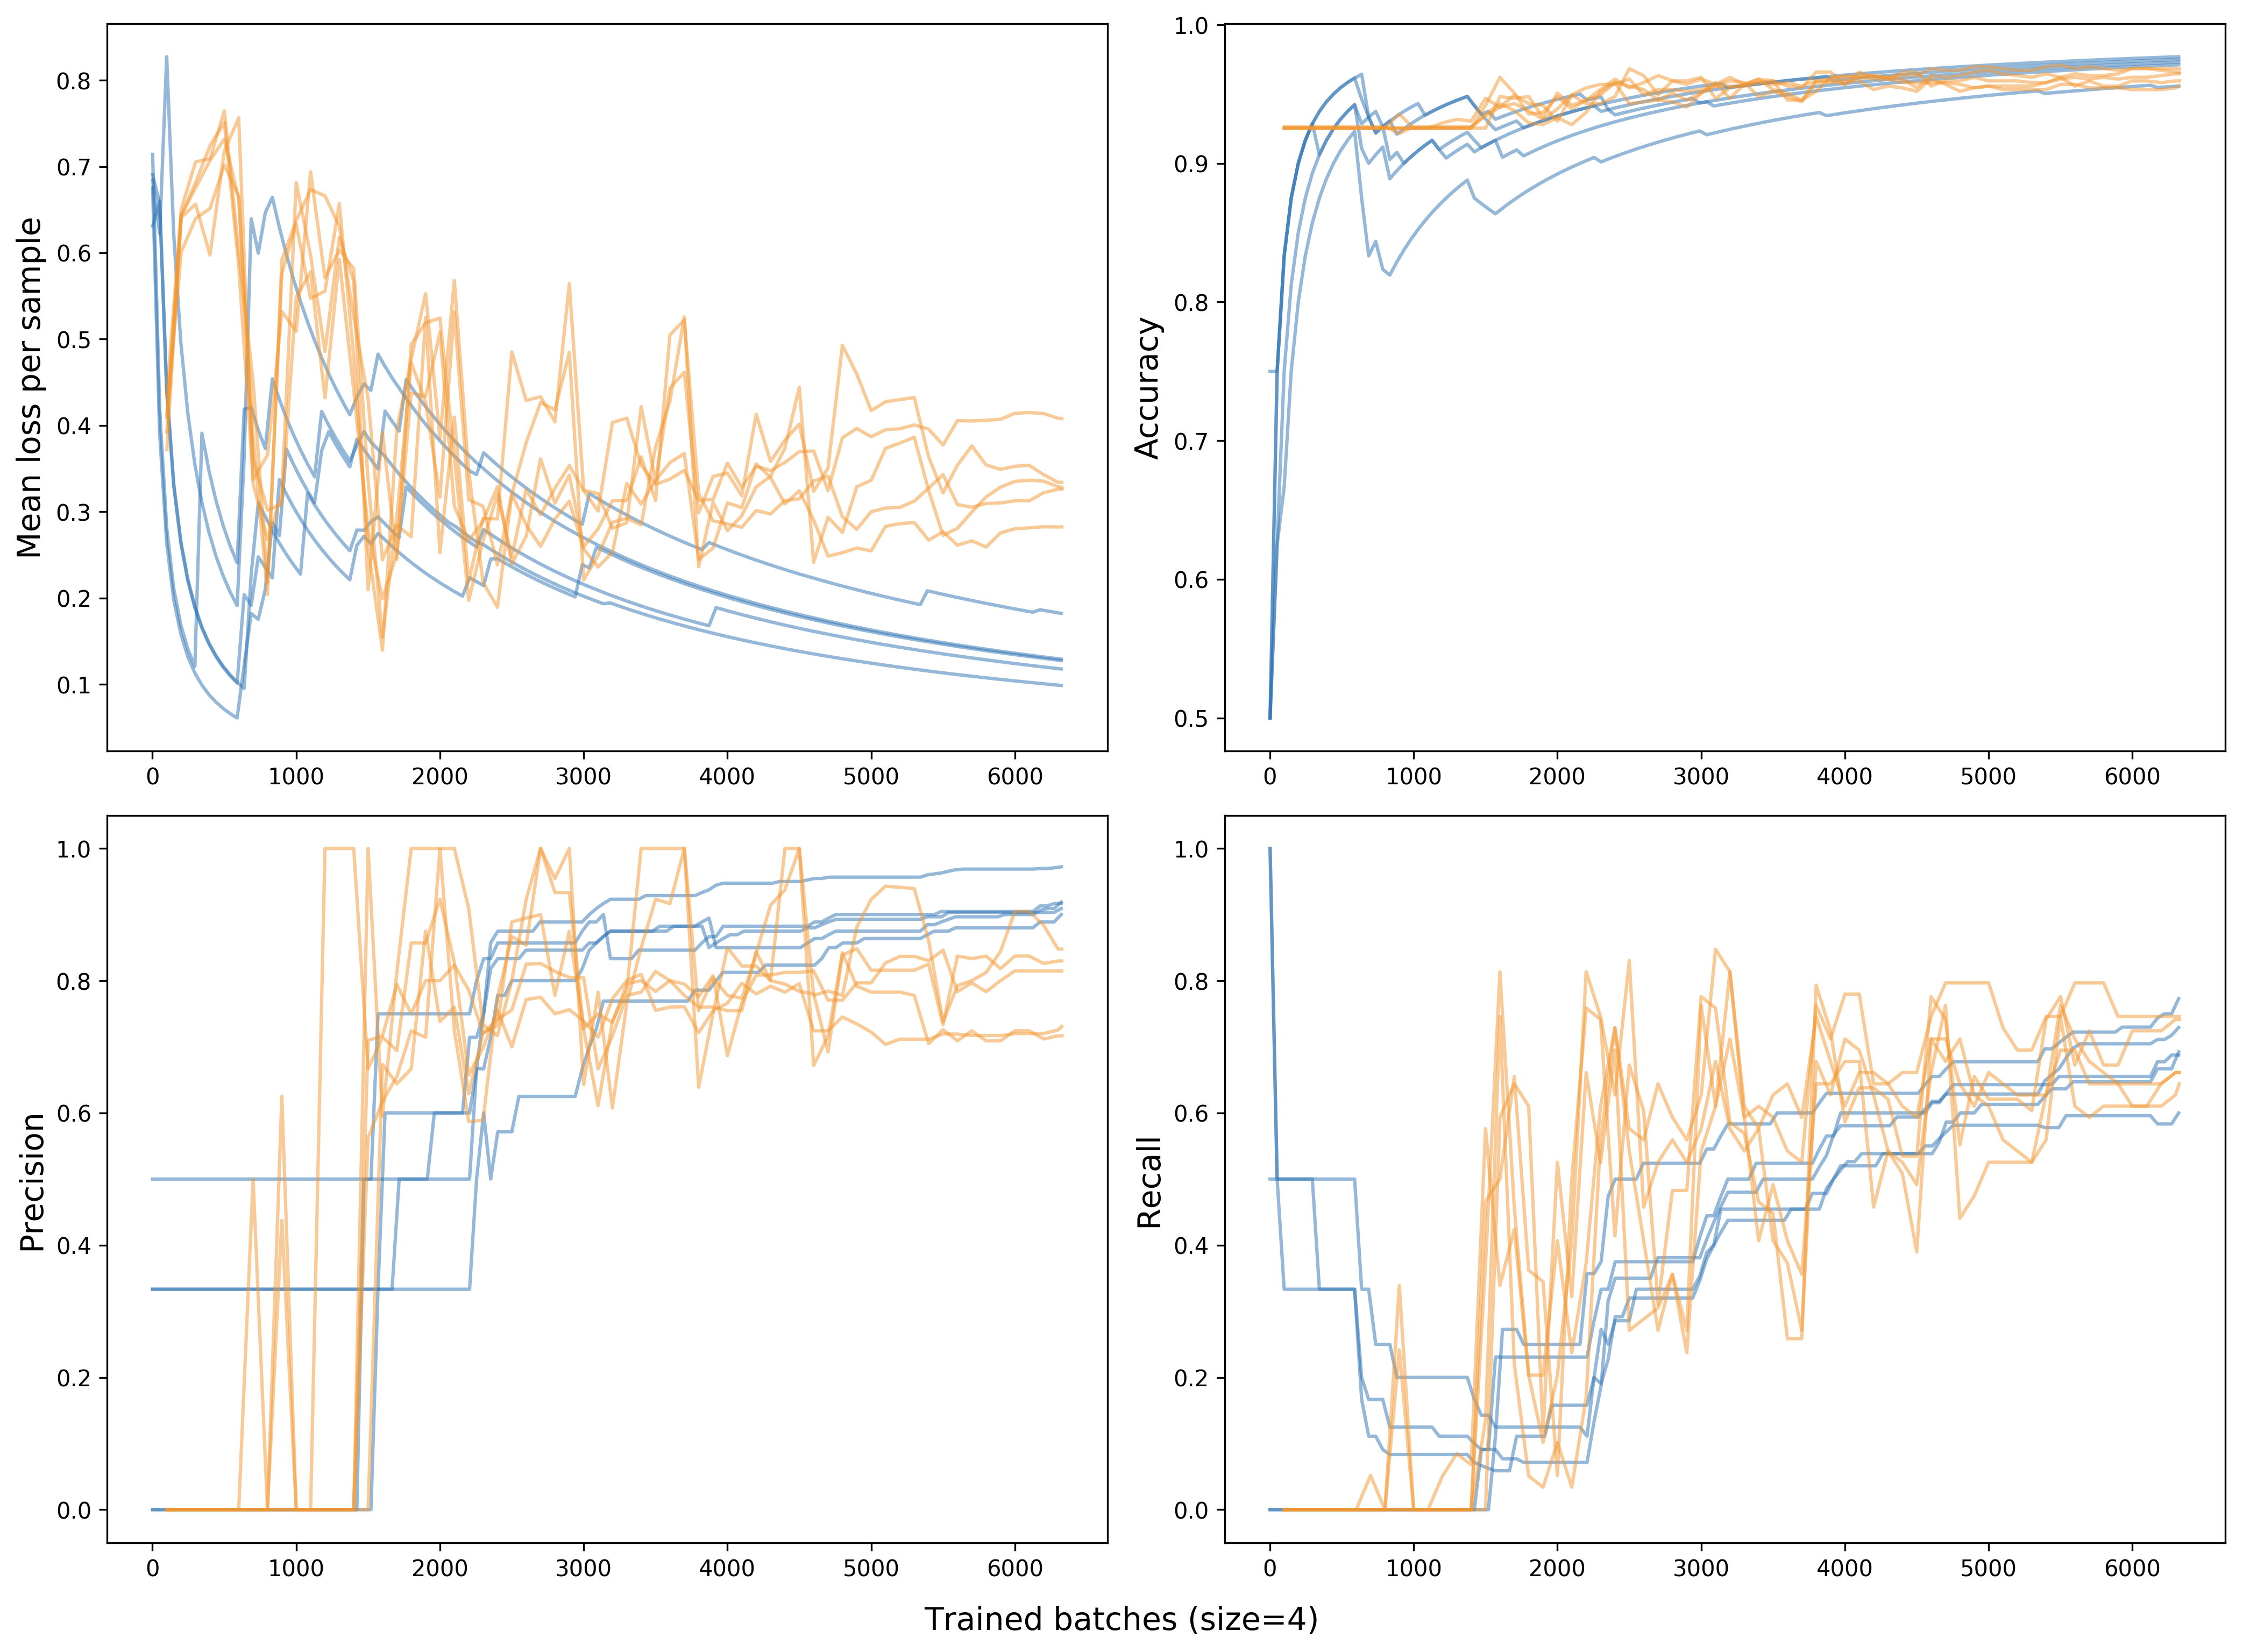

In [267]:
cv_log = TrainingLog.from_csv(
    dirc='/mnt/storage/projects/cs-273/tf_curves/tf_cv_weighted_res/biobert_8/',
    pattern='run_[{model}_8_epoch_weighted_set_{set_num}{type}tag-{tag}].csv',
    name_combine=['type', 'set_num', 'tag']
)
plot_cv_log(cv_log, '/home/yuning/Work/cs-273/figs/biobert_cv_weighted_ep8_all.jpeg')

In [305]:
cv_best_model_stat = get_cv_best_model_stat(
    stat_dir='/mnt/storage/projects/cs-273/tf_curves/tf_cv_weighted_res/biobert_8/',
    pattern='run_[{model}_8_epoch_weighted_set_{set_num}{type}tag-{tag}].csv',
    step_range=[5000, 10000]
)
cv_best_model_stat

step  mean_loss  accuracy  precision    recall        f1  roc_auc_max  \
1  5800.0   0.259098  0.968394   0.783333  0.796610  0.874143     0.996388   
2  5500.0   0.272656  0.962073   0.737705  0.762712  0.850871     0.994813   
3  5500.0   0.377234  0.957016   0.719298  0.694915  0.805173     0.993331   
4  5500.0   0.321788  0.960809   0.733333  0.745763  0.839737     0.994443   
5  5100.0   0.304151  0.959494   0.782609  0.620690  0.753770     0.994818   

   roc_auc_min  
1     0.782463  
2     0.746041  
3     0.679726  
4     0.729462  
5     0.612210

In [307]:
biobert_ep8 = cv_best_model_stat.describe()
biobert_ep8

step  mean_loss  accuracy  precision    recall        f1  \
count     5.000000   5.000000  5.000000   5.000000  5.000000  5.000000   
mean   5480.000000   0.306985  0.961557   0.751256  0.724138  0.824739   
std     248.997992   0.046459  0.004256   0.029741  0.068490  0.046819   
min    5100.000000   0.259098  0.957016   0.719298  0.620690  0.753770   
25%    5500.000000   0.272656  0.959494   0.733333  0.694915  0.805173   
50%    5500.000000   0.304151  0.960809   0.737705  0.745763  0.839737   
75%    5500.000000   0.321788  0.962073   0.782609  0.762712  0.850871   
max    5800.000000   0.377234  0.968394   0.783333  0.796610  0.874143   

       roc_auc_max  roc_auc_min  
count     5.000000     5.000000  
mean      0.994759     0.709980  
std       0.001095     0.065969  
min       0.993331     0.612210  
25%       0.994443     0.679726  
50%       0.994813     0.729462  
75%       0.994818     0.746041  
max       0.996388     0.782463

## BioBert 10 epochs

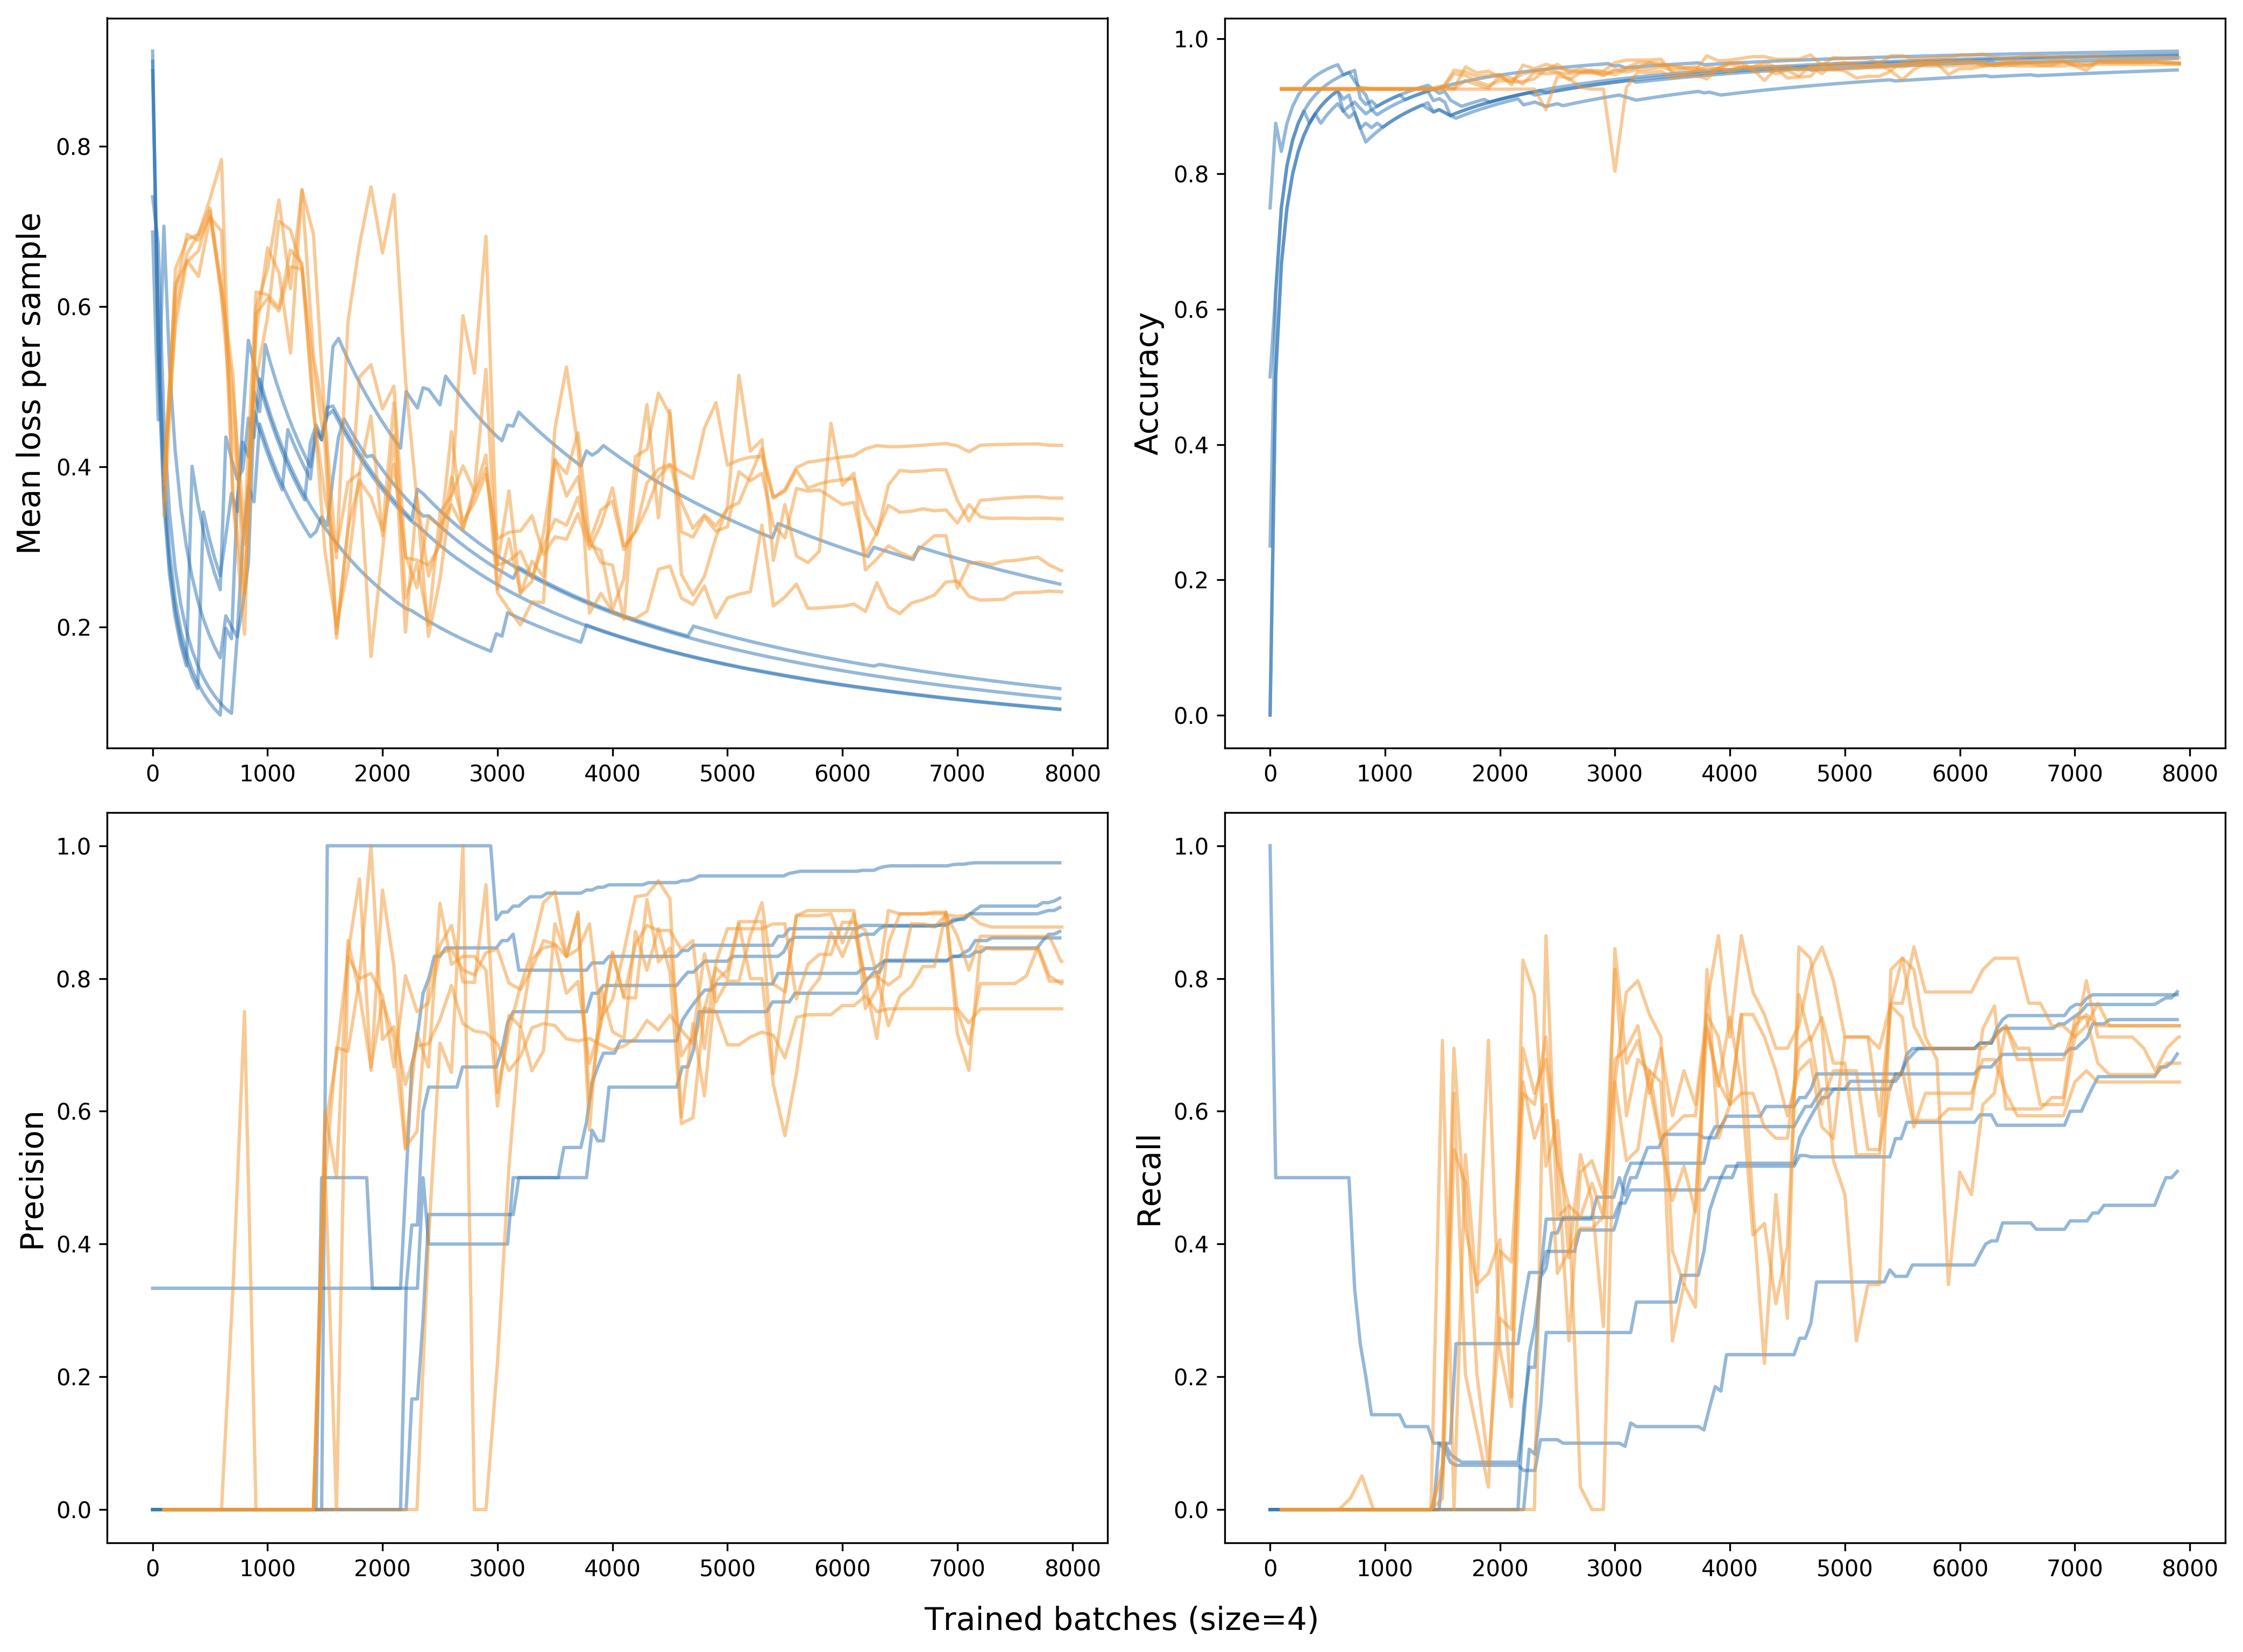

In [271]:
cv_log = TrainingLog.from_csv(
    dirc='/mnt/storage/projects/cs-273/tf_curves/tf_cv_weighted_res/biobert_10/',
    pattern='run_[{model}_10_epoch_weighted_set_{set_num}{type}tag-{tag}].csv',
    name_combine=['type', 'set_num', 'tag']
)
plot_cv_log(cv_log, '/home/yuning/Work/cs-273/figs/biobert_cv_weighted_ep10_all.jpeg')

In [303]:
cv_best_model_stat = get_cv_best_model_stat(
    stat_dir='/mnt/storage/projects/cs-273/tf_curves/tf_cv_weighted_res/biobert_10/',
    pattern='run_[{model}_10_epoch_weighted_set_{set_num}{type}tag-{tag}].csv',
    step_range=[6000, 10000]
)
cv_best_model_stat

step  mean_loss  accuracy  precision    recall        f1  roc_auc_max  \
1  6500.0   0.217022  0.972187   0.803279  0.830508  0.895780     0.997221   
2  7000.0   0.248682  0.960809   0.750000  0.711864  0.817811     0.994489   
3  6100.0   0.414003  0.960809   0.759259  0.694915  0.806512     0.994582   
4  6300.0   0.315592  0.962073   0.784314  0.677966  0.795412     0.995161   
5  6200.0   0.290145  0.965823   0.792453  0.724138  0.827698     0.995854   

   roc_auc_min  
1     0.816894  
2     0.698250  
3     0.682574  
4     0.667778  
5     0.713256

In [304]:
biobert_ep10 = cv_best_model_stat.describe()
biobert_ep10

step  mean_loss  accuracy  precision    recall        f1  \
count     5.000000   5.000000  5.000000   5.000000  5.000000  5.000000   
mean   6420.000000   0.297089  0.964340   0.777861  0.727878  0.828643   
std     356.370594   0.075520  0.004844   0.022488  0.059961  0.039433   
min    6100.000000   0.217022  0.960809   0.750000  0.677966  0.795412   
25%    6200.000000   0.248682  0.960809   0.759259  0.694915  0.806512   
50%    6300.000000   0.290145  0.962073   0.784314  0.711864  0.817811   
75%    6500.000000   0.315592  0.965823   0.792453  0.724138  0.827698   
max    7000.000000   0.414003  0.972187   0.803279  0.830508  0.895780   

       roc_auc_max  roc_auc_min  
count     5.000000     5.000000  
mean      0.995462     0.715750  
std       0.001125     0.059043  
min       0.994489     0.667778  
25%       0.994582     0.682574  
50%       0.995161     0.698250  
75%       0.995854     0.713256  
max       0.997221     0.816894

# Compared to SVM
## Load SVM results

In [124]:
class ResEvaluator(object):
    
    def __init__(self, abstract, labels, prediction, pred_prob):
        self.abstract = abstract
        self.labels = labels
        self.prediction = prediction
        self.pred_prob = pred_prob
        self.false_positives = np.sum((self.prediction == 1) & (self.labels == 0))
        self.false_negatives = np.sum((self.prediction == 0) & (self.labels == 1))
        self.true_positives = np.sum((self.prediction == 1) & (self.labels == 1))
        self.true_negatives = np.sum((self.prediction == 0) & (self.labels == 0))
        self.accuracy = (self.true_positives + self.true_negatives)/(self.true_positives + self.true_negatives + self.false_positives + self.false_negatives)
        self.precision = (self.true_positives)/(self.true_positives + self.false_positives)
        self.recall = (self.true_positives)/(self.true_positives + self.false_negatives)
        self.f1 = (2 * self.precision * self.recall)/(self.precision + self.recall)
        
    @classmethod
    def from_tsv(cls, data_tsv, prediction_tsv, pred_prob_tsv):
        data = pd.read_csv(data_tsv, sep='\t')
        prediction = pd.read_csv(prediction_tsv, sep='\t', names=['pred'])
        pred_prob = pd.read_csv(pred_prob_tsv, sep='\t', names=['negative', 'positive'])
        return cls(abstract=data['text'], labels=data['id'], prediction=prediction['pred'], pred_prob=pred_prob)


In [125]:
svm_cv_res = [ResEvaluator.from_tsv(
    data_tsv='/mnt/storage/projects/cs-273/dataset/cross_validation/set_{}/dev.tsv'.format(set_ix + 1),
    prediction_tsv='/mnt/storage/projects/cs-273/svm/results_cv/cv_test_pred_set_{}.txt'.format(set_ix + 1),
    pred_prob_tsv='/mnt/storage/projects/cs-273/svm/results_cv/cv_test_pred_prob_set_{}.txt'.format(set_ix + 1)
) for set_ix in range(5)]

statistics = ['accuracy', 'precision', 'recall', 'f1']
for stat in statistics:
    print('{}:\t{}'.format(stat, [set_res.__dict__[stat] for set_res in svm_cv_res]))
    print_report(stat, [set_res.__dict__[stat] for set_res in svm_cv_res])

accuracy:	[0.9620733249051833, 0.9646017699115044, 0.9506953223767383, 0.9582806573957017, 0.9607594936708861]
accuracy: 0.9592821136520028 +- 0.010630529325371103
precision:	[0.7457627118644068, 0.7540983606557377, 0.65625, 0.7166666666666667, 0.7142857142857143]
precision: 0.7174126906945052 +- 0.07681647835680376
recall:	[0.7457627118644068, 0.7796610169491526, 0.711864406779661, 0.7288135593220338, 0.7758620689655172]
recall: 0.7483927527761542 +- 0.05879497996474249
f1:	[0.7457627118644068, 0.7666666666666666, 0.6829268292682927, 0.7226890756302521, 0.7438016528925621]
f1: 0.7323693872644361 +- 0.06344017804328574


## Compare SVM results to BioBERT weighted

& Accuracy & Precision & Recall & F1 \
	extbf{BoW + SVM} &$0.959 \pm 0.011$ & $0.717 \pm 0.077$ & $0.748 \pm 0.059$ & $0.732 \pm 0.063$\\
	extbf{weighted BioBERT (8 epchs)} &$0.962 \pm 0.009$ & $0.751 \pm 0.059$ & $0.724 \pm 0.137$ & $0.825 \pm 0.094$\\
	extbf{weighted BioBERT (10 epchs)} &$0.964 \pm 0.010$ & $0.778 \pm 0.045$ & $0.728 \pm 0.120$ & $0.829 \pm 0.079$\\


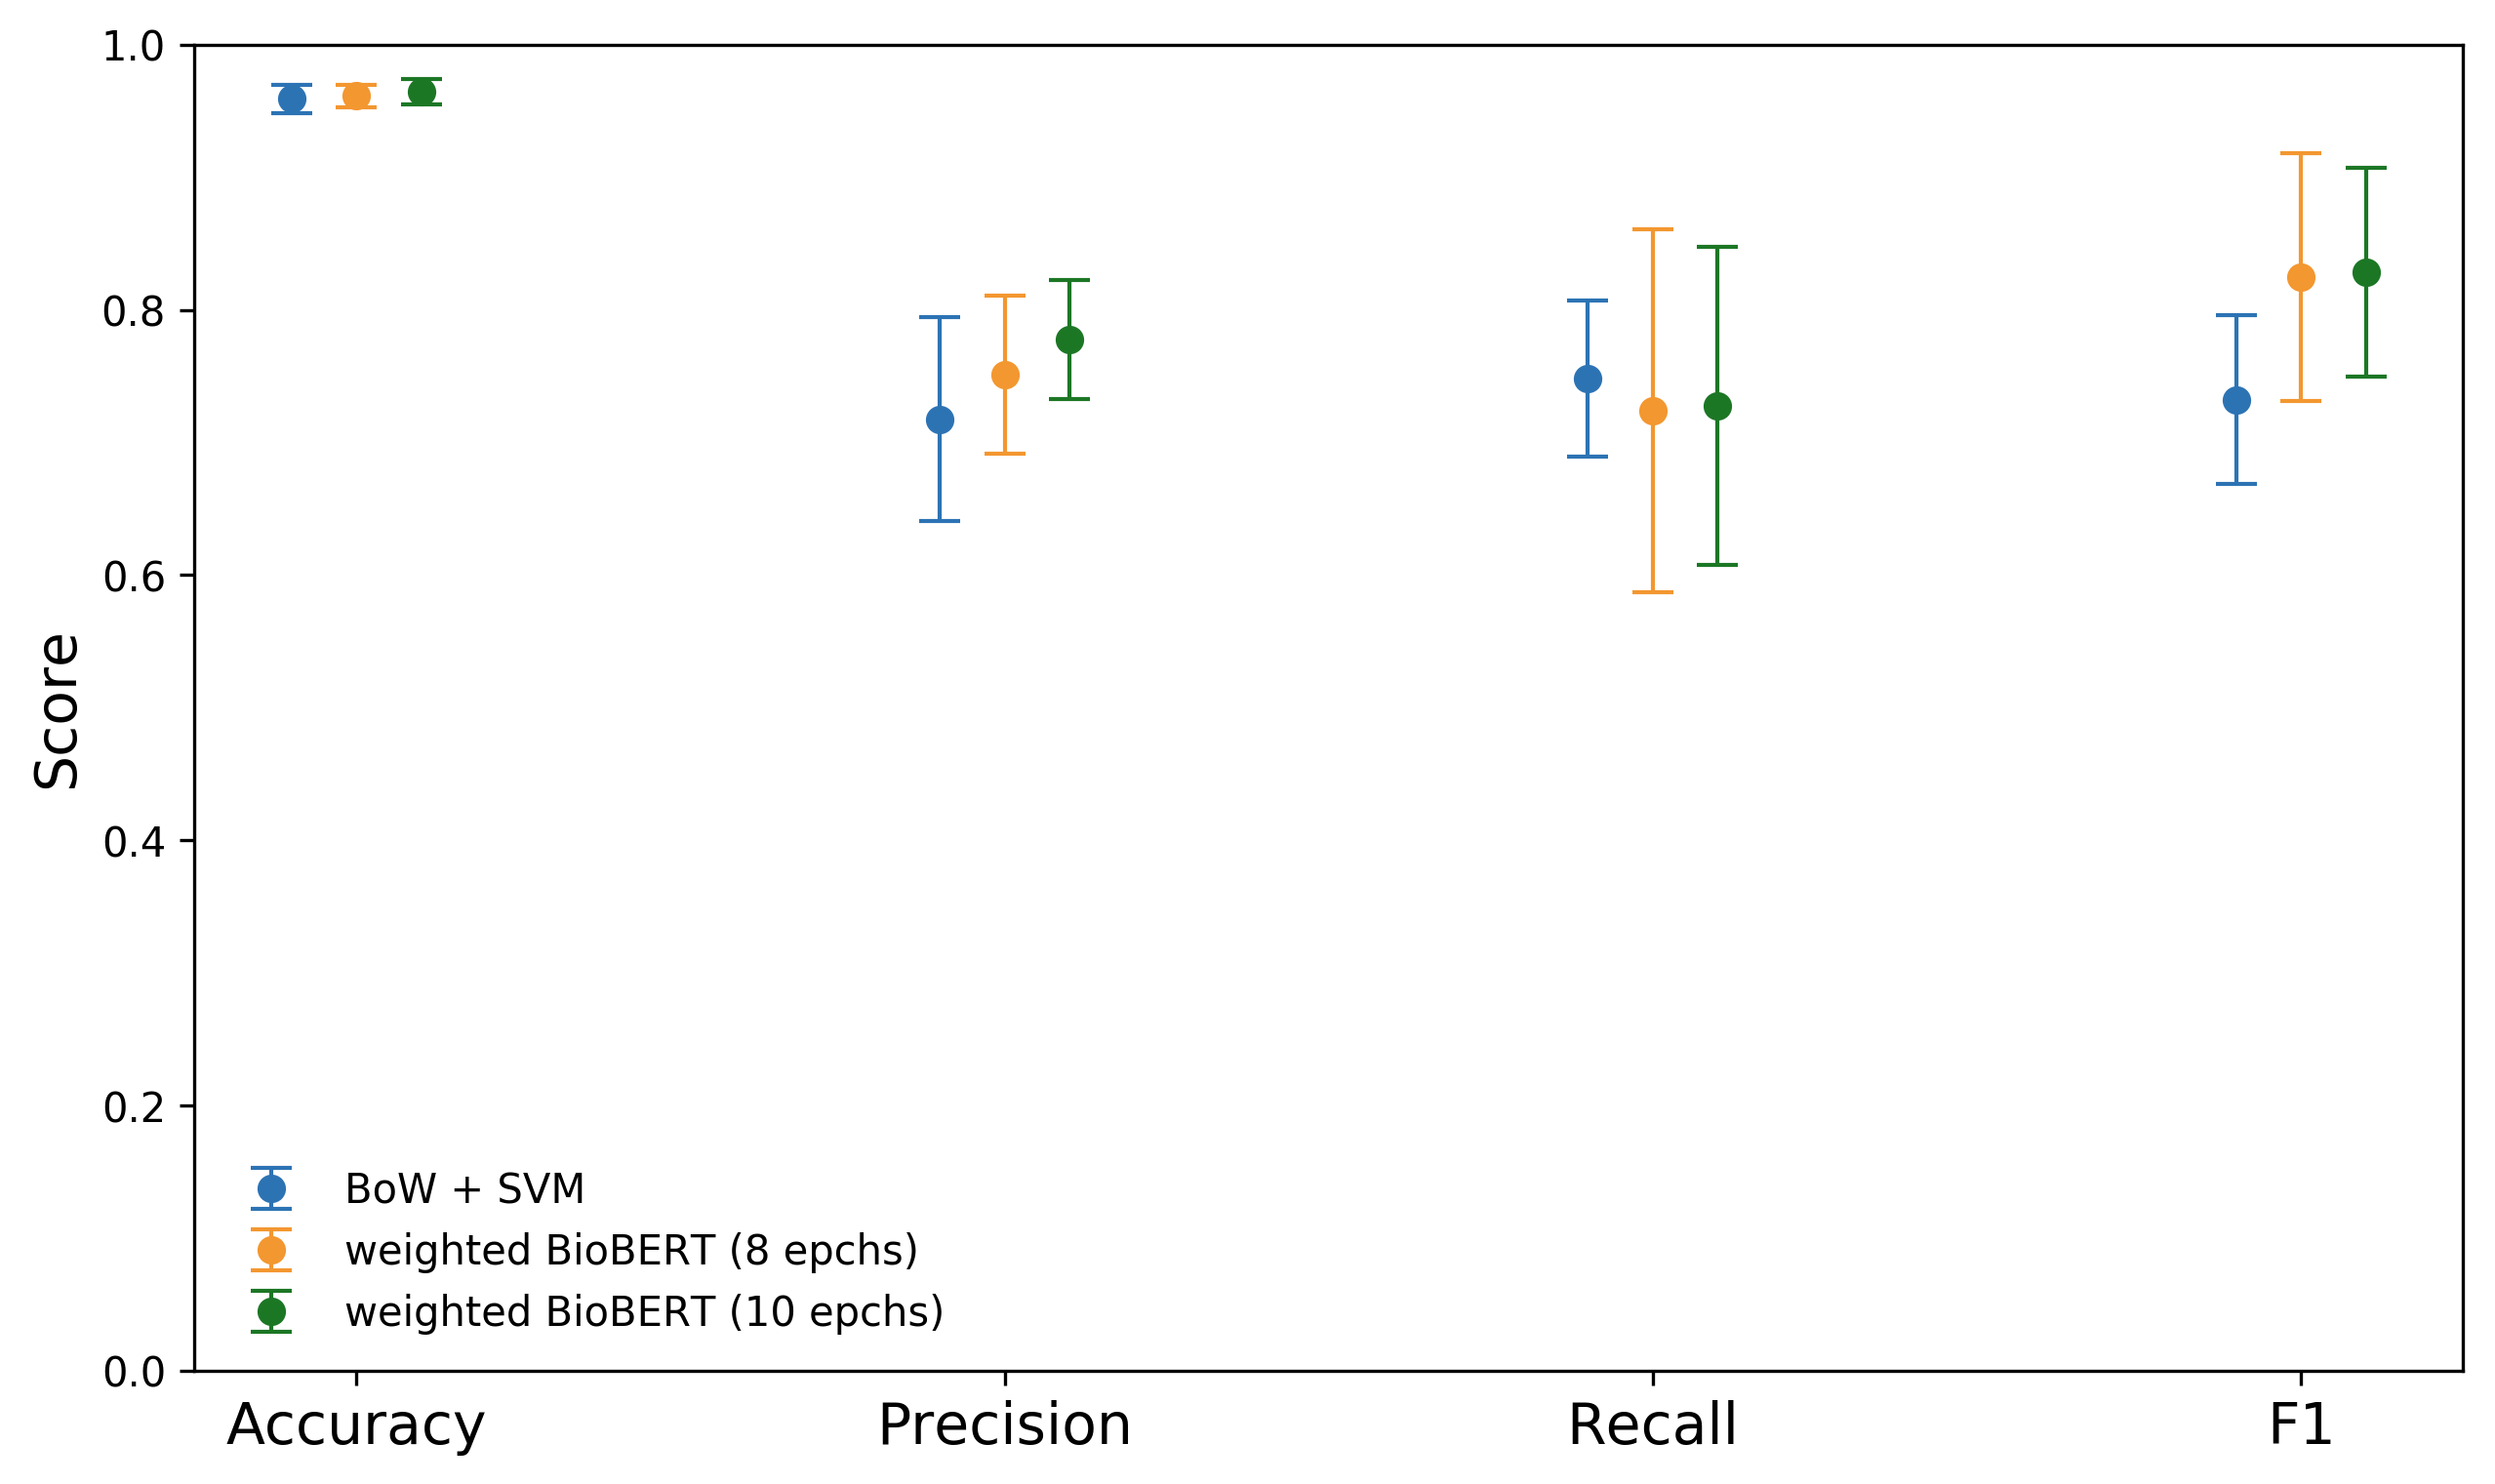

In [316]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
loc = np.array([1, 3, 5, 7])

print(r'& Accuracy & Precision & Recall & F1 \\')

# Plot SVM results
svm_res_mean = [np.mean([set_res.__dict__[stat] for set_res in svm_cv_res]) for stat in statistics]
svm_res_std = np.array(
    [np.std([set_res.__dict__[stat] for set_res in svm_cv_res], ddof=1) for stat in statistics]
)
ax.errorbar(x=loc-0.2, y=svm_res_mean, yerr=2*svm_res_std,
            ls='', marker='o', elinewidth=1, capsize=5, color='#2C73B4', label='BoW + SVM')

print(r'\textbf{BoW + SVM} &' + 
      ' & '.join(['${:.3f} \pm {:.3f}$'.format(svm_res_mean[ix], 2 * svm_res_std[ix]) for ix in range(4)]) +
      r'\\')

# Plot weighted BioBERT trained with 8 epoches
biobert_mean = np.array(
    [biobert_ep8.loc['mean']['accuracy'],
     biobert_ep8.loc['mean']['precision'],
     biobert_ep8.loc['mean']['recall'],
     biobert_ep8.loc['mean']['f1']]
)
biobert_std =  np.array(
    [biobert_ep8.loc['std']['accuracy'],
     biobert_ep8.loc['std']['precision'],
     biobert_ep8.loc['std']['recall'],
     biobert_ep8.loc['std']['f1']]
)

ax.errorbar(x=loc, y=biobert_mean, yerr=2 * biobert_std,
            ls='', marker='o', elinewidth=1, capsize=5, color='#F39730', label='weighted BioBERT (8 epchs)')

print(r'\textbf{weighted BioBERT (8 epchs)} &' + 
      ' & '.join(['${:.3f} \pm {:.3f}$'.format(biobert_mean[ix], 2 * biobert_std[ix]) for ix in range(4)]) +
      r'\\')
# Plot weighted BioBERT trained with 10 epoches
biobert_mean = np.array(
    [biobert_ep10.loc['mean']['accuracy'],
     biobert_ep10.loc['mean']['precision'],
     biobert_ep10.loc['mean']['recall'],
     biobert_ep10.loc['mean']['f1']]
)
biobert_std =  np.array(
    [biobert_ep10.loc['std']['accuracy'],
     biobert_ep10.loc['std']['precision'],
     biobert_ep10.loc['std']['recall'],
     biobert_ep10.loc['std']['f1']]
)

ax.errorbar(x=loc + 0.2, y=biobert_mean, yerr=2 * biobert_std,
            ls='', marker='o', elinewidth=1, capsize=5, color='#1C7725', label='weighted BioBERT (10 epchs)')
print(r'\textbf{weighted BioBERT (10 epchs)} &' + 
      ' & '.join(['${:.3f} \pm {:.3f}$'.format(biobert_mean[ix], 2 * biobert_std[ix]) for ix in range(4)]) +
      r'\\')

ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=14)
ax.set_xlim([0.5, 7.5])
ax.set_xticks([1, 3, 5, 7])
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'], fontsize=14)
ax.legend(frameon=False)
fig.savefig('/home/yuning/Work/cs-273/figs/training_res_compare.jpeg', bbox_inches='tight')

plt.show()